# April 30th, 2021

**Motivation**: Exploring performance of Leiden algorithm.  Here I explore an interesting way of showing evidence for overlapping communities.  If you run Louvain, you get different answers everytime. This behavior extends over to Leiden, a better version of Louvain.  Why do we get a different community strcuture everytime? Because, there is no real truth.  We use the result of running Leiden 10,000 times to infer something about overlapping structure.  This can be used in conjunction with Blei or Fortunato algorithm to make stronger claims. Here we use K-means and Allen's anatomical atlas parcellation and see that Allen atlas in its current form is not working. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        im = axes[1, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(pearson, spearman, atlas, figsize=None, colorbar=False):
    thresholds = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(thresholds)) if figsize is None else figsize
    fig, axes = plt.subplots(len(thresholds), 2, figsize=figsize)

    for ii, th in enumerate(sorted(thresholds, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[ii, 0].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=10, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        im = axes[ii, 1].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=10, y=1.03)
        axes[ii, 1].set_ylabel('th = {:.2f}\n'.format(th), fontsize=10)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(organized_data: dict, include: List = None, config: Config = None):
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = [i for i in regions if i < 24] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy().astype(float)
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy()
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)
    y = np.ma.masked_where(contour, x)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas_limited': x,
        'contour': contour,
        'atlas_masked': y,
    }
    return output

## Allen atlas visualization

In [3]:
config = Config()

num_regions = 256
subject = 6
session = 1
run = 1

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    config=config,
    subject=subject,
    session=session,
    run=run,
)

In [4]:
atls_org = organize_atlas(load)

In [5]:
atls_org['mapping']

{0: 'background',
 1: 'R-Primary motor area',
 2: 'R-Secondary motor area',
 3: 'R-Primary somatosensory area, nose',
 4: 'R-Primary somatosensory area, barrel field',
 5: 'R-Primary somatosensory area, lower limb',
 6: 'R-Primary somatosensory area, mouth',
 7: 'R-Primary somatosensory area, upper limb',
 8: 'R-Primary somatosensory area, trunk',
 9: 'R-Primary somatosensory area, unassigned',
 10: 'R-Supplemental somatosensory area',
 11: 'R-Dorsal auditory area',
 12: 'R-Primary auditory area',
 13: 'R-Posterior auditory area',
 14: 'R-Anterolateral visual area',
 15: 'R-Anteromedial visual area',
 16: 'R-Lateral visual area',
 17: 'R-Primary visual area',
 18: 'R-Posterolateral visual area',
 19: 'R-posteromedial visual area'}

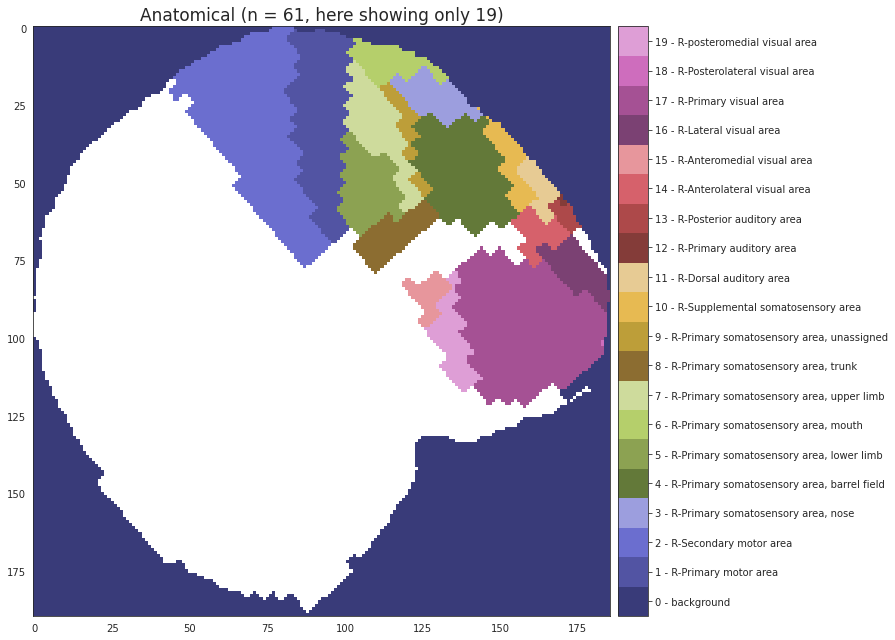

In [6]:
fig, ax = plt.subplots(figsize=(13.5, 9))
vmin = min(atls_org['mapping']) - 0.5
vmax = len(atls_org['mapping']) - 0.5
cax = ax.imshow(atls_org['atlas_limited'], cmap='tab20b', interpolation='none', vmin=vmin, vmax=vmax)

msg = 'Anatomical (n = {:d}, here showing only {:d})'
msg = msg.format(len(atls_org['regions']), len(atls_org['mapping']) - 1)
plt.title(msg, fontsize=17)

cbar = fig.colorbar(cax, ticks=[item for item in atls_org['mapping']], pad=0.01)
tick_labels = ['{:d} - {:s}'.format(k, v) for k, v in atls_org['mapping'].items()]
cbar.ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

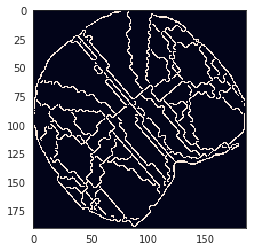

In [7]:
plt.imshow(atls_org['contour'], interpolation='none')

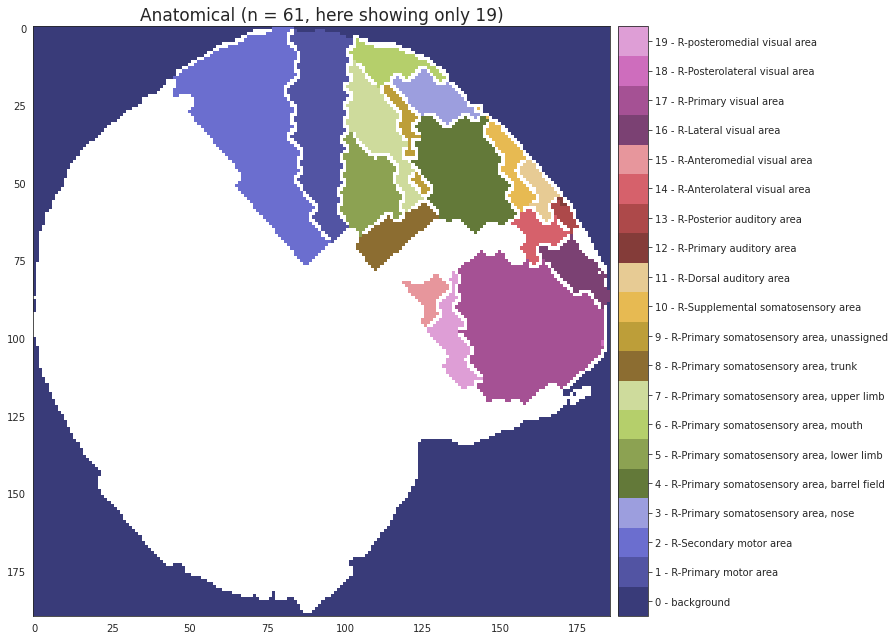

In [8]:
fig, ax = plt.subplots(figsize=(13.5, 9))
vmin = min(atls_org['mapping']) - 0.5
vmax = len(atls_org['mapping']) - 0.5
cax = ax.imshow(atls_org['atlas_masked'], cmap='tab20b', interpolation='none', vmin=vmin, vmax=vmax)

msg = 'Anatomical (n = {:d}, here showing only {:d})'
msg = msg.format(len(atls_org['regions']), len(atls_org['mapping']) - 1)
plt.title(msg, fontsize=17)

cbar = fig.colorbar(cax, ticks=[item for item in atls_org['mapping']], pad=0.01)
tick_labels = ['{:d} - {:s}'.format(k, v) for k, v in atls_org['mapping'].items()]
cbar.ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

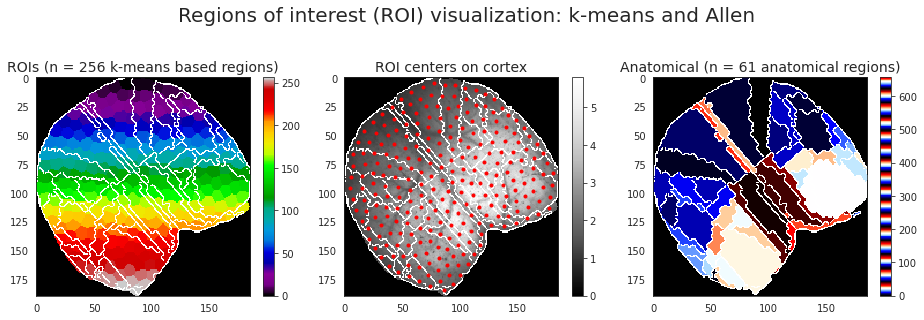

In [9]:
sns.set_style('white')
plt.figure(figsize=(13, 4.5))
plt.subplot(131)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['atlas_kmeans']),
           cmap='nipy_spectral', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('ROIs (n = {:d} k-means based regions)'.format(num_regions), fontsize=14)

plt.subplot(132)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['ref']), cmap='Greys_r', interpolation='none')
for j, i in load['kmeans_centers']: 
    plt.plot(i, j, marker='o', color='r', markersize=3)
plt.colorbar(shrink=0.8)
plt.title('ROI centers on cortex', fontsize=14)
    
plt.subplot(133)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['atlas']), cmap='flag_r', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('Anatomical (n = {:d} anatomical regions)'.format(len(atls_org['regions'])), fontsize=14)

sup = plt.suptitle('Regions of interest (ROI) visualization: k-means and Allen', fontsize=20, y=1.01)
plt.tight_layout()

plt.savefig('kmeans_atlas_{:d}.pdf'.format(num_regions), dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

## K-means parcellation

### Community structure

#### Louvain

In [10]:
data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    data_all[run] = _load
    
    # normalize
    mean = np.mean([item.mean() for item in _load['ca'].values()])
    sd = np.mean([item.std() for item in _load['ca'].values()])
    _ca = {k: (v - mean) / sd for k, v in _load['ca'].items()}
    _df = pd.DataFrame.from_dict(_ca)
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

1             2             3             4             5    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.018567     -0.019268     -0.018573     -0.019975     -0.012233   
std        0.300022      0.356432      0.327446      0.258883      0.324477   
min       -1.029204     -1.167565     -1.201996     -1.056114     -1.314063   
25%       -0.216048     -0.259642     -0.233899     -0.185013     -0.227129   
50%       -0.020831     -0.021058     -0.018897     -0.023031     -0.016689   
75%        0.172461      0.209950      0.196467      0.137881      0.196039   
max        1.347141      1.504027      1.543090      1.300926      1.433223   

                6             7             8             9             10   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.019579     -0.013274     -0.017254     -0.019225     -0.021240   
std        0.219455      0.402799      0.436301      0.402445      0.474195   
min       -0.833822     -1.454804     -1.525023     -1.447802     -1.656101   
25%       -0.159971     -0.285777     -0.317266     -0.278159     -0.331987   
50%       -0.027243     -0.019785     -0.031258     -0.014661     -0.006576   
75%        0.110576      0.250332      0.263158      0.240053      0.290073   
max        1.093910      1.907842      2.077952      2.087863      2.202855   

       ...           247           248           249           250  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.047454     -0.038794     -0.033164     -0.021091   
std    ...      0.920687      0.696547      0.636424      0.516440   
min    ...     -3.307437     -2.339551     -2.198961     -1.838139   
25%    ...     -0.652003     -0.500764     -0.447824     -0.359018   
50%    ...     -0.033552     -0.032187     -0.032476     -0.027565   
75%    ...      0.551793      0.411178      0.365958      0.295209   
max    ...      5.481783      5.063040      4.234665      4.673918   

                251           252           253           254           255  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.032738     -0.032049     -0.033366     -0.021179     -0.025392   
std        0.467836      0.527120      0.565671      0.453883      0.461031   
min       -1.674815     -1.869581     -2.148521     -1.642093     -1.831903   
25%       -0.340461     -0.382036     -0.409294     -0.319254     -0.333764   
50%       -0.026000     -0.030728     -0.028511     -0.031004     -0.031090   
75%        0.274132      0.304013      0.324155      0.259512      0.265411   
max        2.418522      3.231462      3.528874      3.124887      2.864861   

                256  
count  22000.000000  
mean      -0.011155  
std        0.360292  
min       -1.268252  
25%       -0.251294  
50%       -0.021981  
75%        0.209070  
max        2.397520  

[8 rows x 256 columns]

In [11]:
thresholds = [0.75, 0.78, 0.79, 0.80, 0.81, 0.82]
corrs = get_corrs(df, thresholds=thresholds)

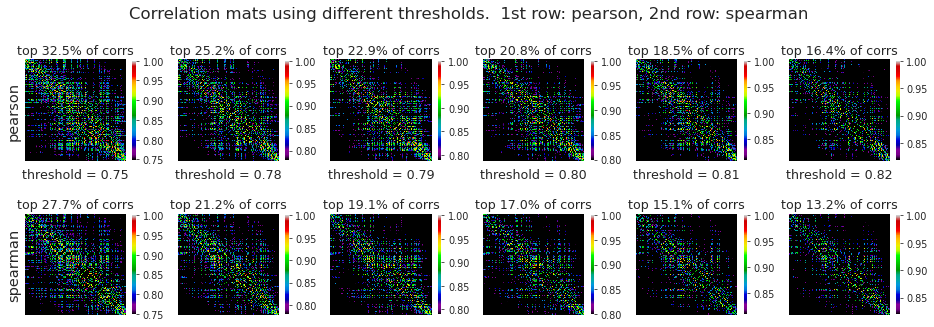

In [12]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

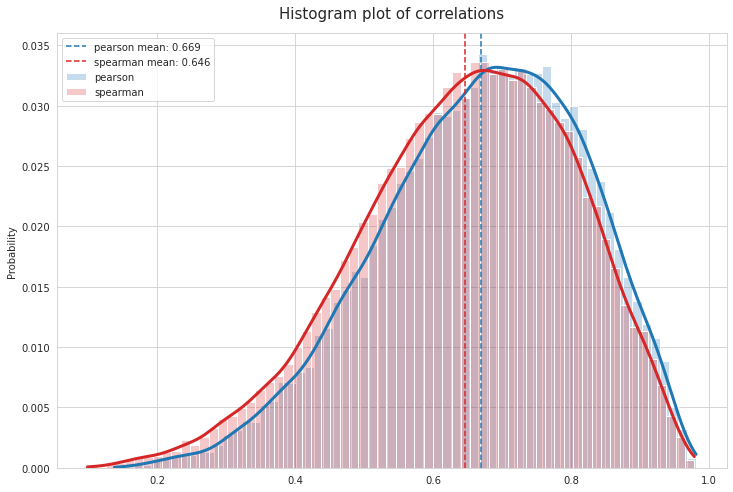

In [13]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [14]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [15]:
results_louvain = run_louvain(graphs[0.8], res=np.logspace(-0.3, 0.3, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

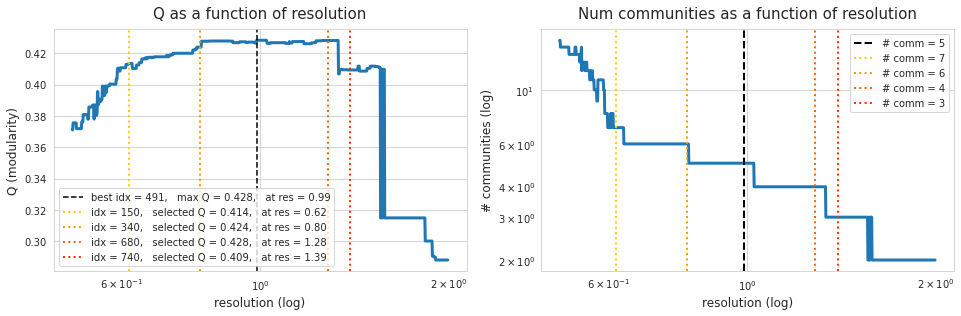

In [16]:
selected_idxs = [150, 340, 680, 740]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

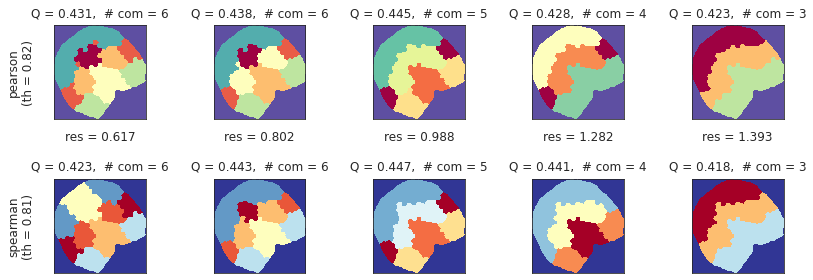

In [17]:
# selected_idxs = [450, 540, 585, 680] # [440, 520, 530, 590]

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.82,
    spearman_th=0.81,
    figsize=(12, 4),
    colorbar=False, )

#### Leiden

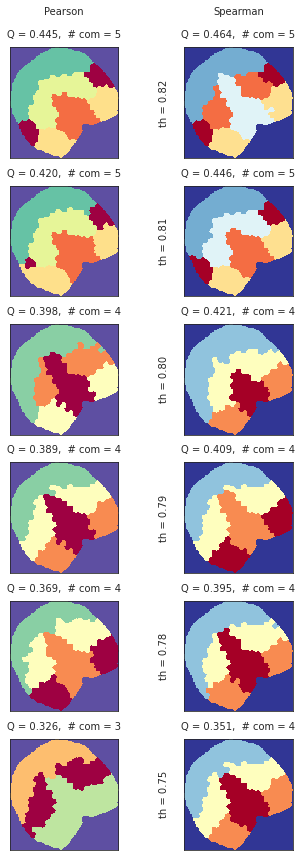

In [18]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    figsize=None,
    colorbar=False,
)

### Evidence for overlapping?

In [12]:
field_names=('idx', 'num_comm', 'modularity', 'partition', 'comm_mat', 'comm_proto')
Leiden = collections.namedtuple('Leiden', field_names=field_names)

In [13]:
th = 0.81
n = 10000
g = nx.from_numpy_matrix(corrs['spearman'][th])

# get results
results_leiden = defaultdict(list)
for i in tqdm(range(n)):
    coms = cdlib_algorithms.leiden(g, weights='weight')
    community_list = sorted(coms.communities, key=lambda x: len(x), reverse=True)
    partition = convert('community', 'partition', community=community_list)
    output = filter_islands(partition, load['atlas_kmeans'], node_labels, min_com_size=3)
    q = nx_comm.modularity(g, communities=community_list)
    num_comm = len(set(partition.values()))

    comm_proto = {}
    for j in range(num_comm):
        a = np.zeros_like(output['comm_mat'])
        a[output['comm_mat'] == j] = 1
        comm_proto[j] = a.flatten()

    results = Leiden(
        idx=i,
        num_comm=num_comm,
        modularity=q,
        partition=partition,
        comm_mat=output['comm_mat'],
        comm_proto=comm_proto,
    )
    results_leiden[num_comm].append(results)

results_leiden = dict(results_leiden)
results_leiden = dict(sorted(results_leiden.items(), key=lambda x: len(x[1]), reverse=True))


# get modularity values
q_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        q_leiden[k].append(result.modularity)
q_leiden = dict(q_leiden)


# get prototypes
proto_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        for proto in result.comm_proto.values():
            proto_leiden[k].append(proto)
proto_leiden = dict(proto_leiden)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
{k: len(v) for k, v in results_leiden.items()}

{5: 7500, 4: 2499, 3: 1}

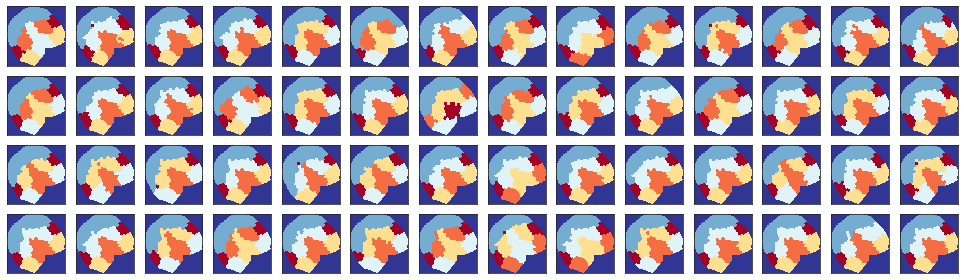

In [15]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[0]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

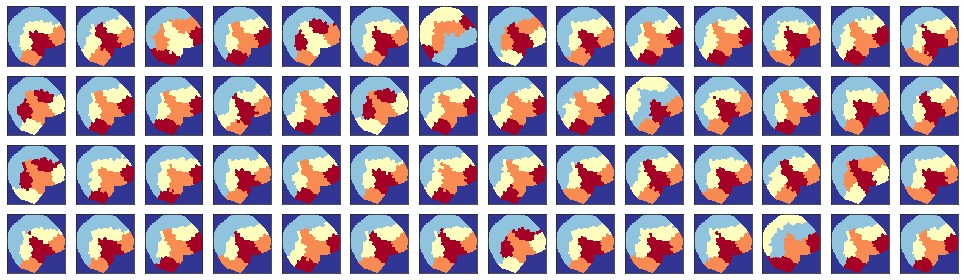

In [16]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[1]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

...merging dicts: 0it [00:00, ?it/s]

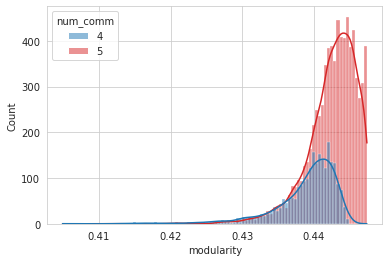

In [17]:
dict_list = []

for k, v in q_leiden.items():
    if len(v) < n / 10:
        continue
    dict_list.append({'num_comm': [k] * len(v), 'modularity': v})

sns.set_style('whitegrid')
sns.histplot(
    data=pd.DataFrame.from_dict(merge_dicts(dict_list)),
    x='modularity',
    hue='num_comm',
    palette=['C0', 'C3'],
    kde=True,
)
plt.show()

In [18]:
proto_all = [x.reshape(1, -1) for item in proto_leiden.values() for x in item]
proto_all = np.concatenate(proto_all)
proto_all.shape

(47499, 35340)

#### Quantize (k-means)

In [19]:
n_clusters = list(results_leiden.keys())[0]

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
).fit(proto_all)

In [20]:
# from sklearn.preprocessing import normalize as sk_normalize
from copy import deepcopy as dc

In [21]:
clusters = dc(kmeans.cluster_centers_)
clusters_binarized = dc(kmeans.cluster_centers_)
clusters_binarized
clusters_binarized[clusters_binarized <= 0.01] = 0
clusters_binarized[clusters_binarized > 0.01] = 1

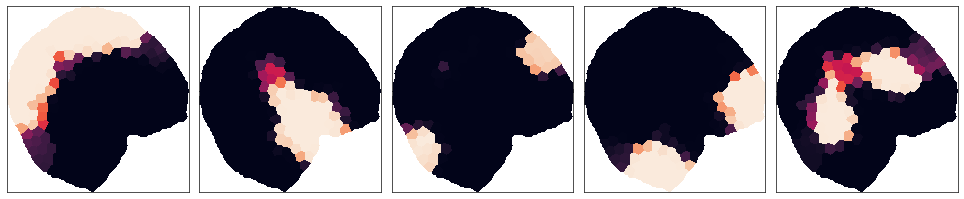

In [22]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

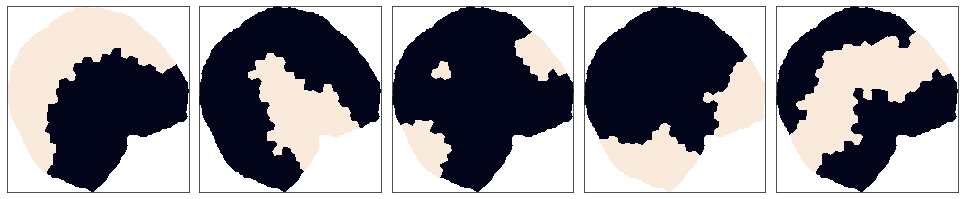

In [23]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

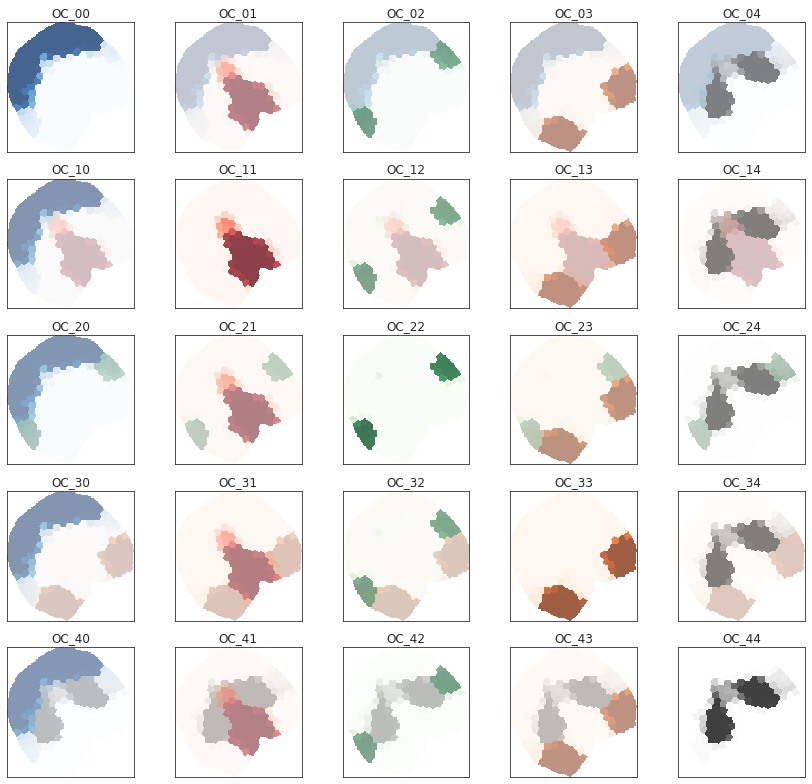

In [24]:
cmaps = {
    0: 'Blues',
    1: 'Reds',
    2: 'Greens',
    3: 'Oranges',
    4: 'Greys',
    5: 'Purples',
}

fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

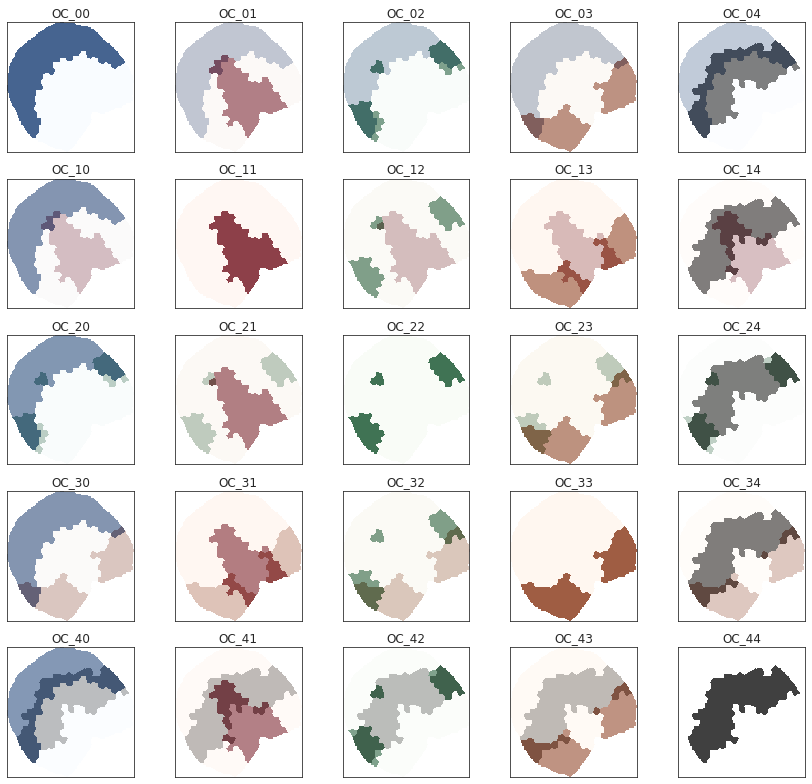

In [25]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

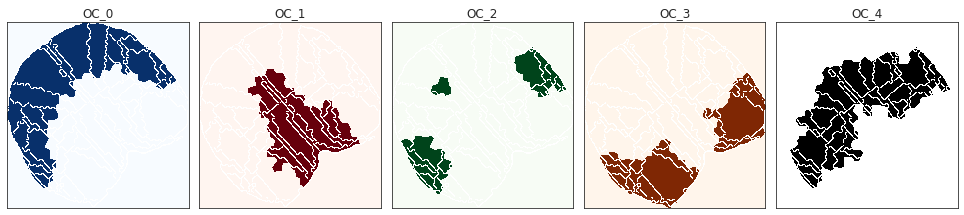

In [26]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [27]:
results_leiden_fixed = []

for result in tqdm(results_leiden[n_clusters], leave=False):
    b = np.ones_like(result.comm_mat) * -1
    for i in range(n_clusters):
        a = np.zeros_like(result.comm_mat)
        a[result.comm_mat == i] = 1
        cluster_idx = kmeans.predict(a.reshape(1, -1)).item()
        b[result.comm_mat == i] = cluster_idx
    results_leiden_fixed.append(b[np.newaxis, ...])
    
results_leiden_fixed = np.concatenate(results_leiden_fixed)
avg_leiden = results_leiden_fixed.mean(0)

results_leiden_fixed.shape, avg_leiden.shape

  0%|          | 0/7500 [00:00<?, ?it/s]

((7500, 190, 186), (190, 186))

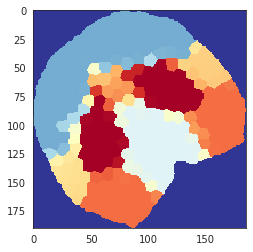

In [28]:
plt.imshow(avg_leiden, cmap='RdYlBu_r', interpolation='none')

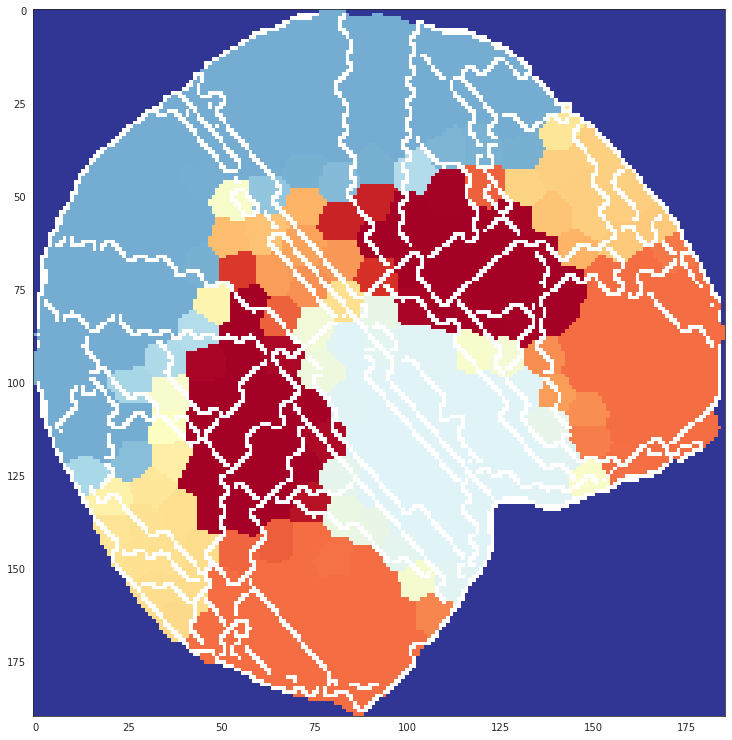

In [29]:
plt.figure(figsize=(15, 13))
plt.imshow(np.ma.masked_where(atls_org['contour'], avg_leiden), cmap='RdYlBu_r', interpolation='none')
plt.show()

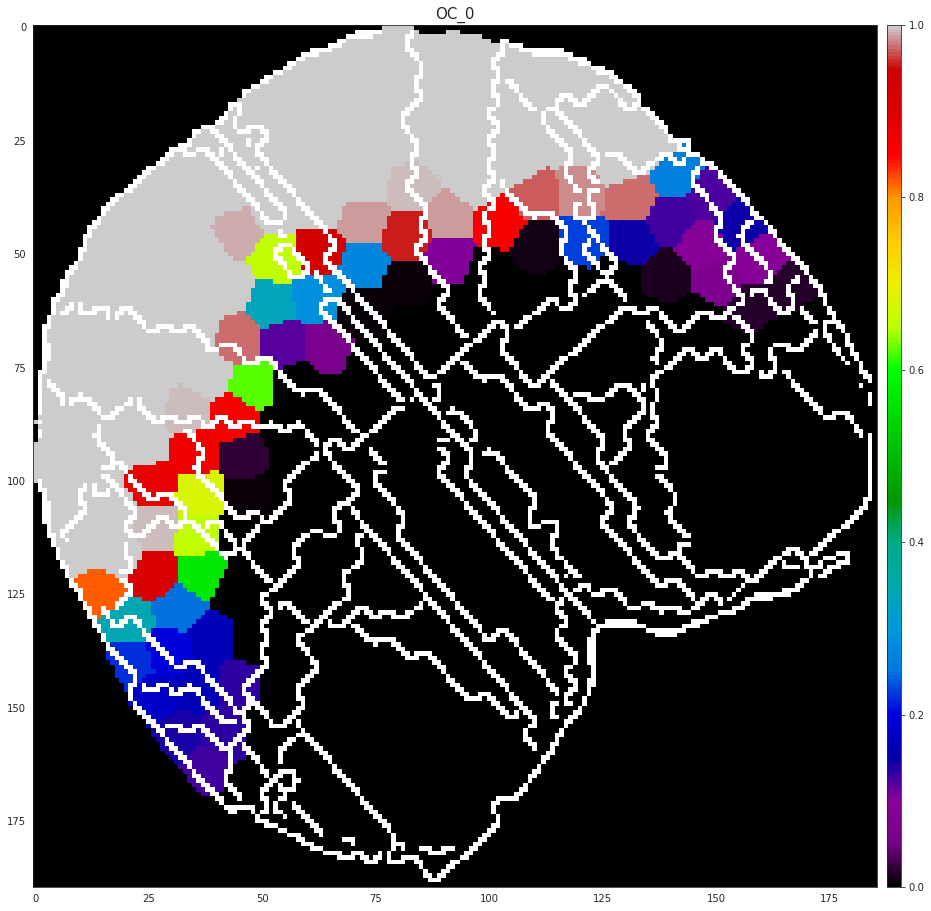

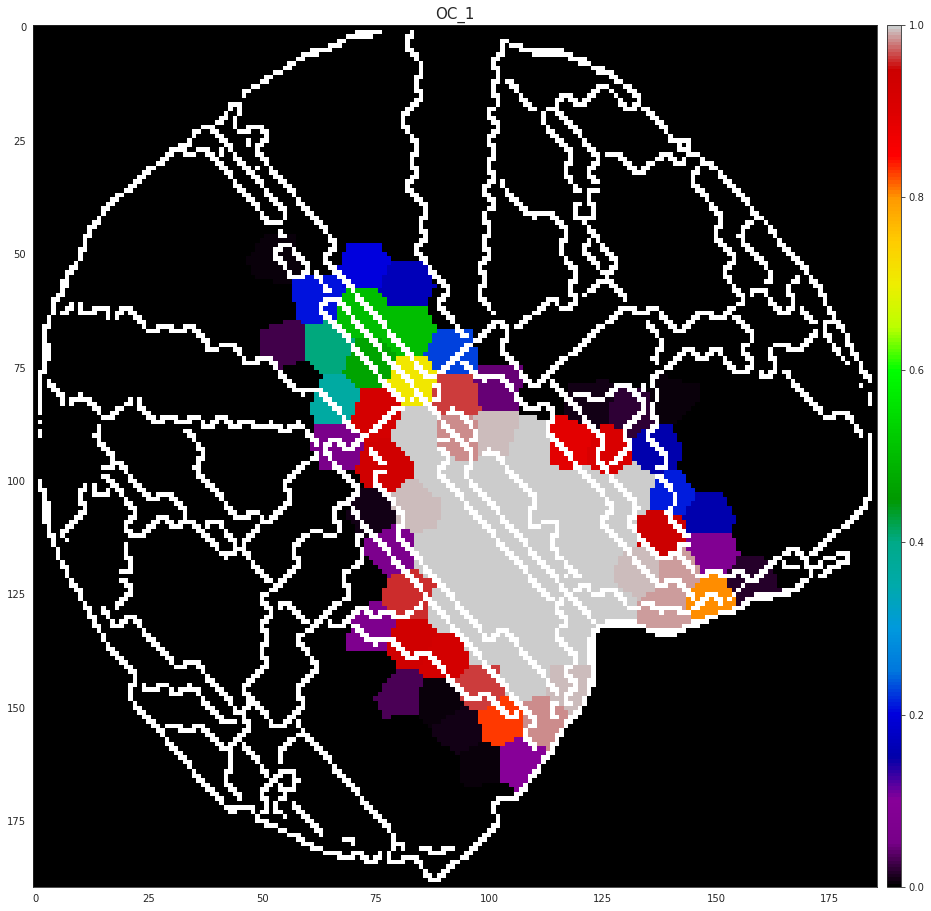

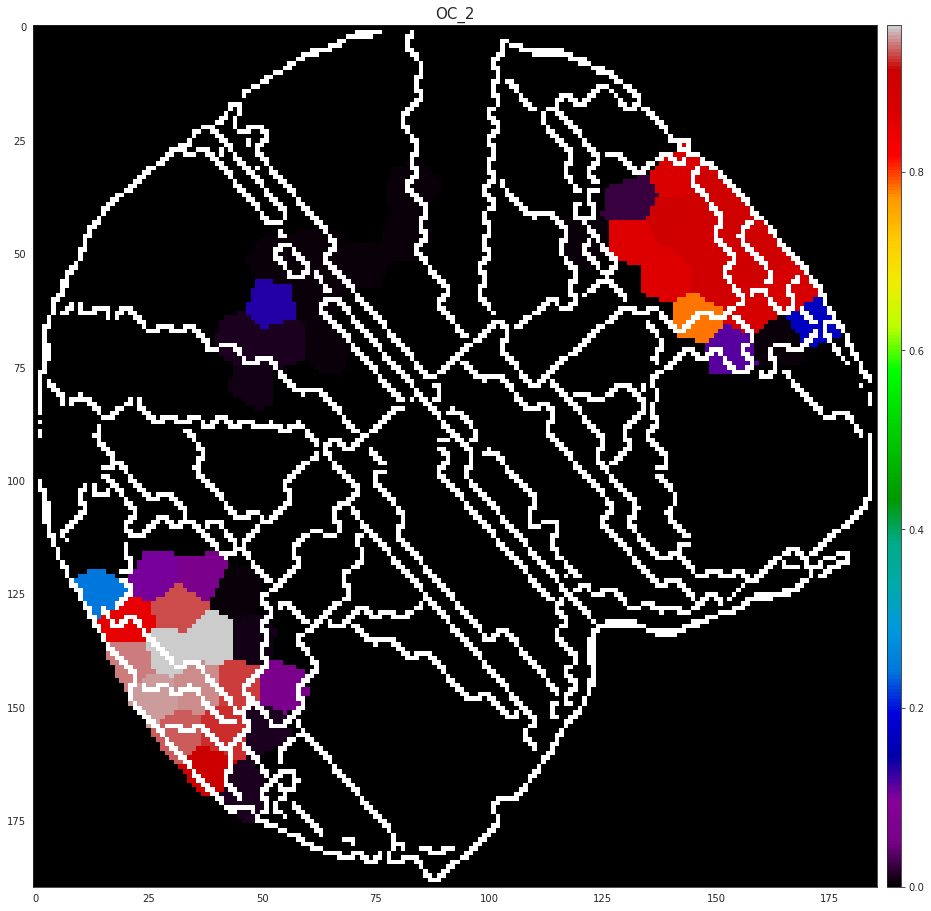

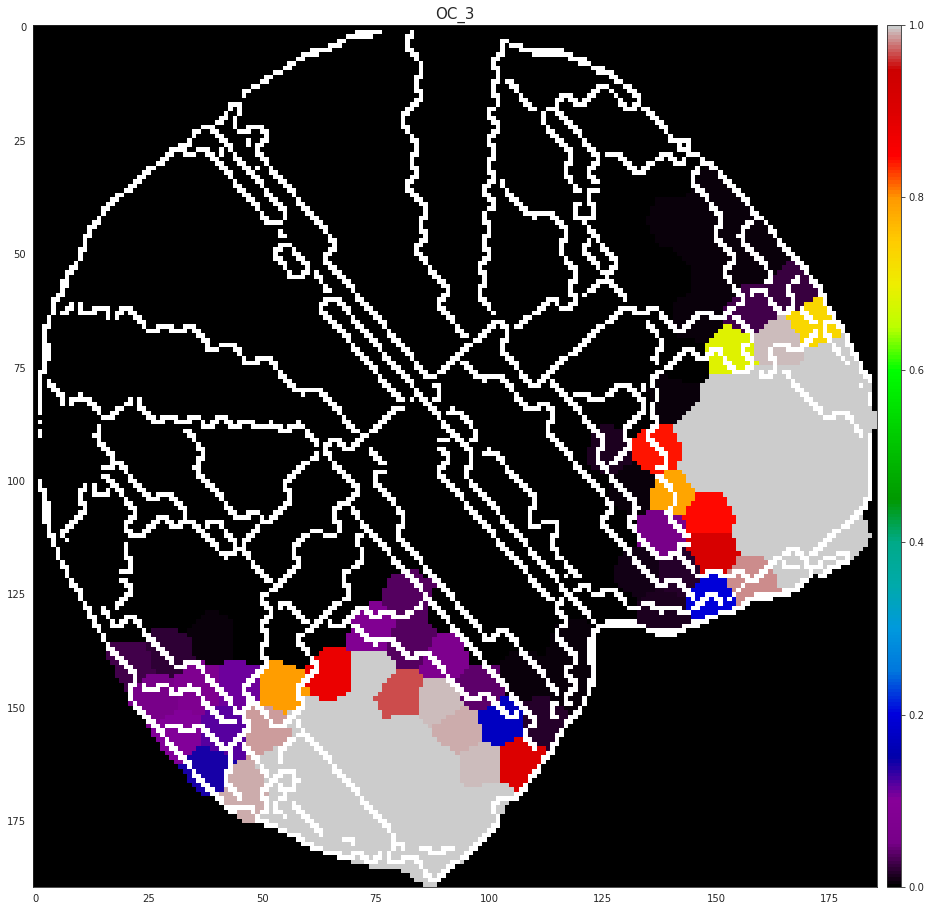

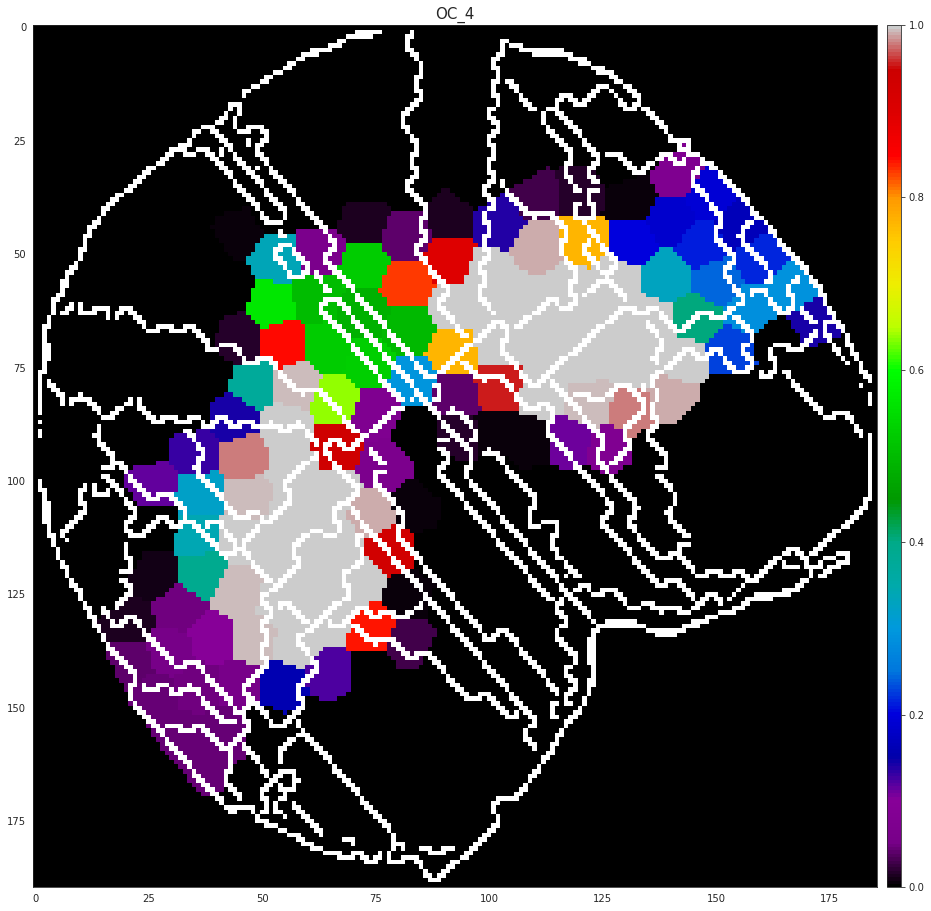

In [30]:
for i in range(n_clusters):
    plt.figure(figsize=(18, 17))
    c = clusters[i].reshape(load['atlas'].shape)
    plt.imshow(np.ma.masked_where(atls_org['contour'], c), cmap='nipy_spectral', interpolation='none')
    plt.colorbar(pad=0.01, shrink=0.933, aspect=60)
    plt.title('OC_{:d}'.format(i), fontsize=15)
    plt.show()

In [31]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        _proto = [item.reshape(1, -1) for item in result.comm_proto.values()]
        canonical_idxs = kmeans.predict(np.concatenate(_proto))
        reindexing = {i: key for i, key in enumerate(canonical_idxs)}
        canonical_partition = {node: reindexing[comm_idx] for node, comm_idx in result.partition.items()}
        nodes, canonical_comm_idxs = tuple(zip(*canonical_partition.items()))
        
        data_dict = {
            'num_comm': [k] * len(nodes),
            'node': nodes,
            'OC_idx': canonical_comm_idxs,
        }
        dict_list.append(data_dict)
        
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [32]:
memberships = np.zeros((n_clusters, len(df.node.unique())))

for node in df.node.unique():
    selected_df = df.loc[df.node == node]
    for idx, num in collections.Counter(selected_df.OC_idx).most_common():
        memberships[idx, node] = num / len(selected_df)


node2roi = {node: load['atlas_kmeans'] == node_labels[node] for node in g.nodes}

cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

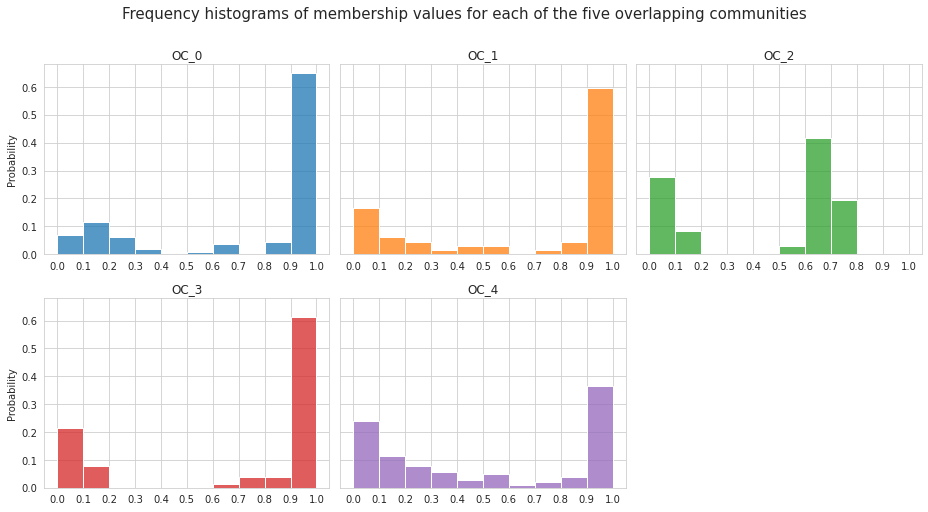

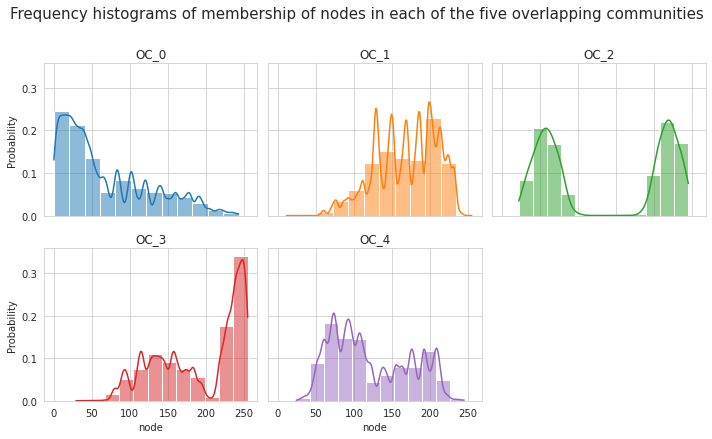

In [33]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//3, idx%3
    sns.histplot(
        memberships[idx][cluster_members[idx]],
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
    axes[i, j].set_xticks(bins)
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex='all', sharey='all')

for idx in df.OC_idx.unique():
    i, j = idx//3, idx%3
    selected_df = df.loc[df.OC_idx == idx]
    sns.histplot(
        data=selected_df,
        x='node',
        stat='probability',
        bins=12,
        color='C{:d}'.format(idx),
        kde=True,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

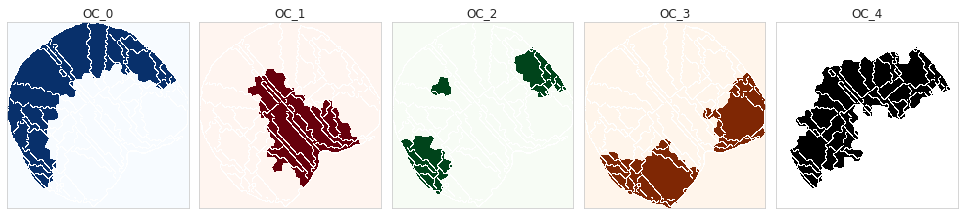

In [34]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

### Quantize (NMF)

In [35]:
from sklearn.decomposition import NMF

In [36]:
nmf = NMF(
    n_components=n_clusters,
    init='nndsvd',
    random_state=42,
)

In [37]:
nmf_pred = nmf.fit_transform(proto_all)

In [38]:
nmf.reconstruction_err_

4209.143182655418

In [39]:
from copy import deepcopy as dc

In [40]:
nmf_clusters = dc(nmf.components_)
nmf_clusters_binarized = dc(nmf.components_)
nmf_clusters_binarized[nmf_clusters_binarized <= 0.01] = 0
nmf_clusters_binarized[nmf_clusters_binarized > 0.01] = 1

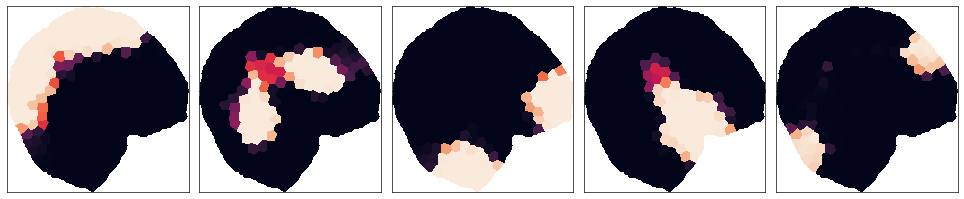

In [41]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

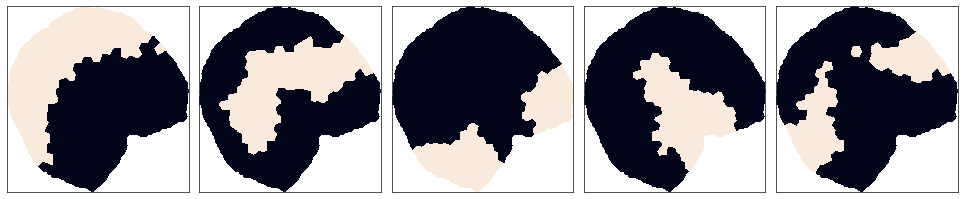

In [42]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

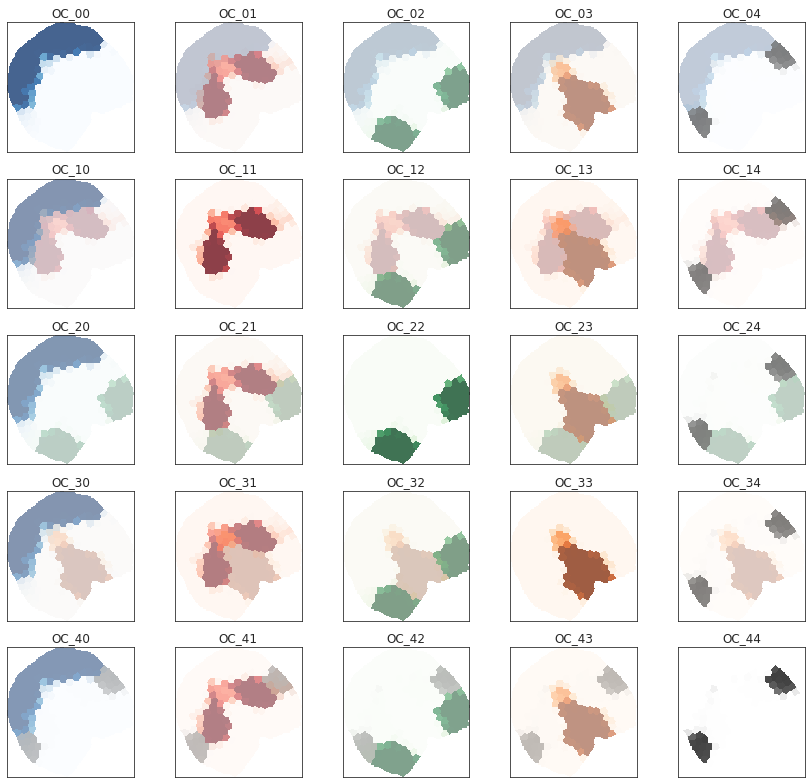

In [43]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

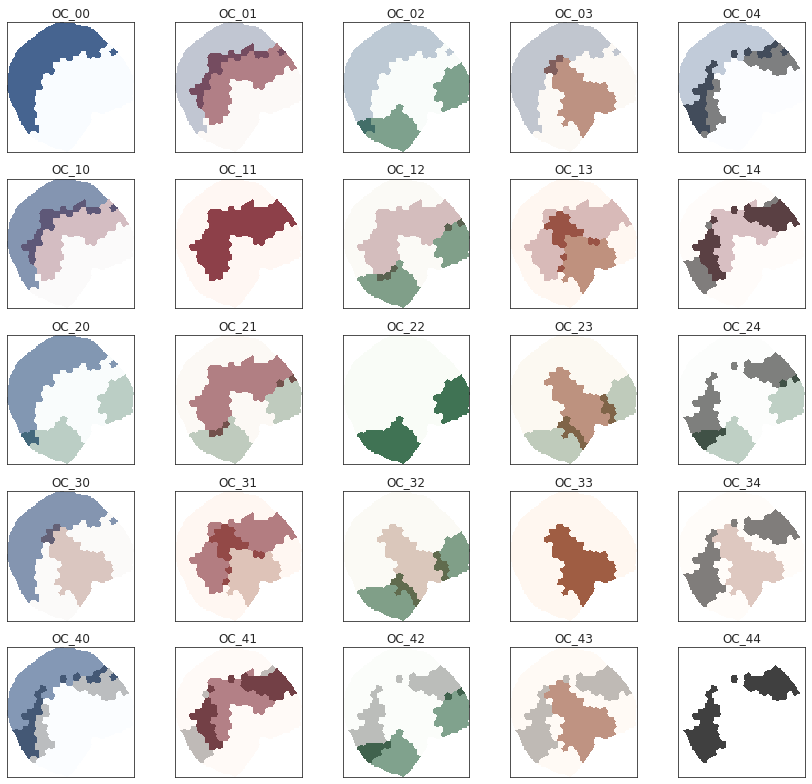

In [44]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

In [45]:
node2roi = {node: load['atlas_kmeans'] == node_labels[node] for node in g.nodes}
cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * nmf_clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

In [46]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        for proto_mat in result.comm_proto.values():
            pred = nmf.transform(proto_mat.reshape(1, -1))
            pred = pred.flatten()
            pred /= pred.sum()

            nodes_inside = list(itertools.compress(
                data=list(node2roi.keys()),
                selectors=[(roi*proto_mat.reshape(roi.shape)).sum() for roi in node2roi.values()]
            ))
            for node in nodes_inside:
                data_dict = {
                    'num_comm': [k] * len(pred),
                    'node': [node] * len(pred),
                    'OC_idx': range(len(pred)),
                    'membership': pred,
                }
                dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/7500 [00:00<?, ?it/s]

  0%|          | 0/2499 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

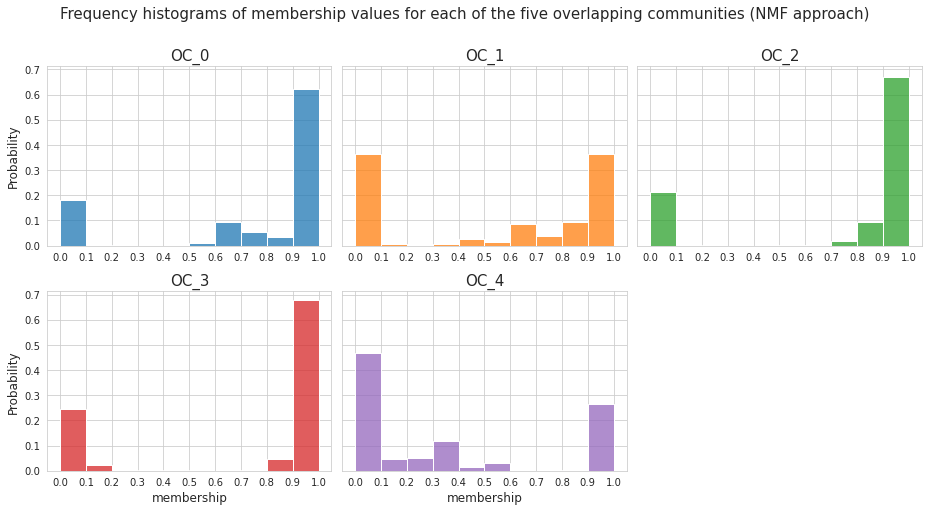

  0%|          | 0/5 [00:00<?, ?it/s]

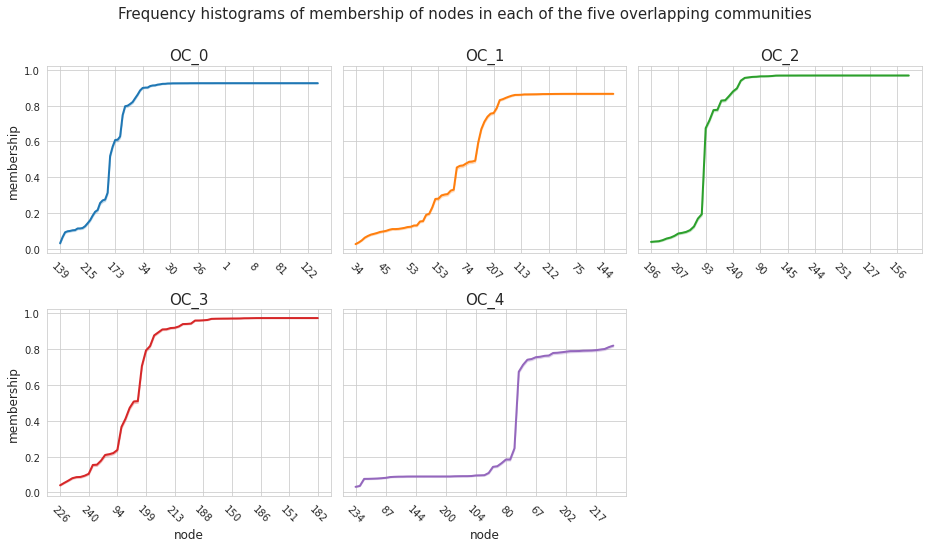

In [47]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//3, idx%3
    
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    sns.histplot(
        data=selected_df,
        x='membership',
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    axes[i, j].set_xticks(bins)
    
    axes[i, j].set_ylabel('Probability', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities (NMF approach)'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13, 7.5), sharey='all')

num_ticks = 10
for idx in tqdm(df.OC_idx.unique(), leave=False):
    i, j = idx//3, idx%3
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    nodes_sorted = selected_df.groupby('node').mean().sort_values('membership').index.tolist()
    node_rank = {node: i for i, node in enumerate(nodes_sorted)}
    ranked_df = pd.concat([selected_df, pd.DataFrame(columns=['node_rank'])], axis=1)
    ranked_df.loc[:, 'node_rank'] = [node_rank[node] for node in ranked_df.node]

    sns.lineplot(
        data=ranked_df,
        x='node_rank',
        y='membership',
        color='C{:d}'.format(idx),
        lw=2,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    
    delta = int(np.ceil(len(node_rank) / num_ticks))
    xticks = range(0, len(node_rank), delta)
    xtick_labels = np.array(list(node_rank))[xticks]
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xtick_labels, rotation=-45)
    axes[i, j].set_ylabel('membership', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('node', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
    
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

### Same idea, different th

In [48]:
th = 0.78
n = 10000
g = nx.from_numpy_matrix(corrs['spearman'][th])

# get results
results_leiden = defaultdict(list)
for i in tqdm(range(n)):
    coms = cdlib_algorithms.leiden(g, weights='weight')
    community_list = sorted(coms.communities, key=lambda x: len(x), reverse=True)
    partition = convert('community', 'partition', community=community_list)
    output = filter_islands(partition, load['atlas_kmeans'], node_labels, min_com_size=3)
    q = nx_comm.modularity(g, communities=community_list)
    num_comm = len(set(partition.values()))

    comm_proto = {}
    for j in range(num_comm):
        a = np.zeros_like(output['comm_mat'])
        a[output['comm_mat'] == j] = 1
        comm_proto[j] = a.flatten()

    results = Leiden(
        idx=i,
        num_comm=num_comm,
        modularity=q,
        partition=partition,
        comm_mat=output['comm_mat'],
        comm_proto=comm_proto,
    )
    results_leiden[num_comm].append(results)

results_leiden = dict(results_leiden)
results_leiden = dict(sorted(results_leiden.items(), key=lambda x: len(x[1]), reverse=True))


# get modularity values
q_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        q_leiden[k].append(result.modularity)
q_leiden = dict(q_leiden)


# get prototypes
proto_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        for proto in result.comm_proto.values():
            proto_leiden[k].append(proto)
proto_leiden = dict(proto_leiden)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [59]:
{k: len(v) for k, v in results_leiden.items()}

{4: 9160, 5: 779, 3: 61}

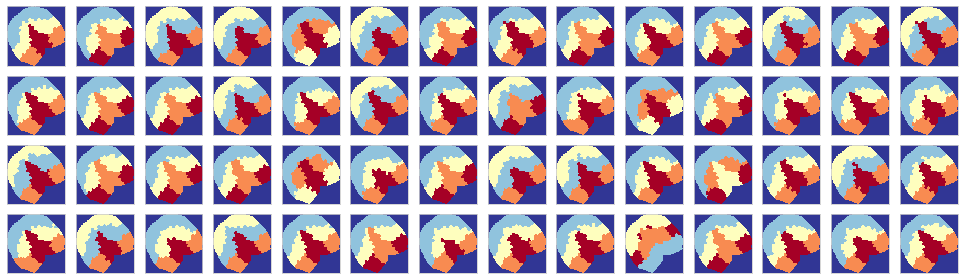

In [60]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(results_leiden[4][idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

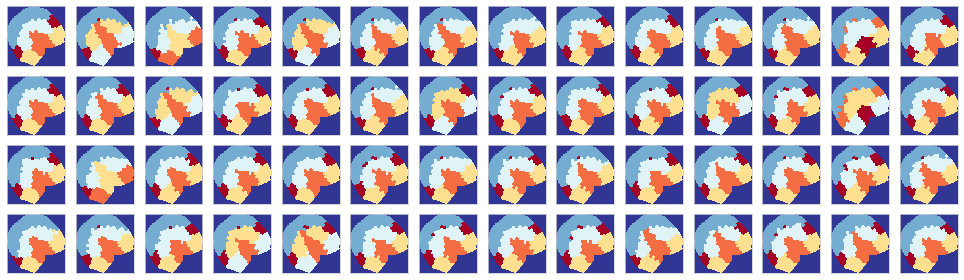

In [61]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(results_leiden[5][idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

...merging dicts: 0it [00:00, ?it/s]

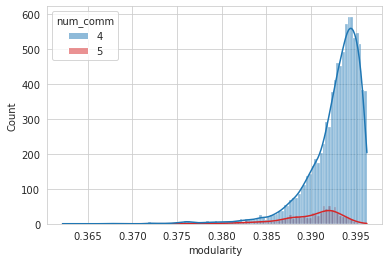

In [63]:
dict_list = []

for k, v in q_leiden.items():
    if len(v) < n / 20:
        continue
    dict_list.append({'num_comm': [k] * len(v), 'modularity': v})

sns.set_style('whitegrid')
sns.histplot(
    data=pd.DataFrame.from_dict(merge_dicts(dict_list)),
    x='modularity',
    hue='num_comm',
    palette=['C0', 'C3'],
    kde=True,
)
plt.show()

In [65]:
proto_all = [x.reshape(1, -1) for item in proto_leiden.values() for x in item]
proto_all = np.concatenate(proto_all)
proto_all.shape

(40718, 35340)

### Quantize (k-means)

In [66]:
n_clusters = list(results_leiden.keys())[0]

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
).fit(proto_all)

In [67]:
# from sklearn.preprocessing import normalize as sk_normalize
from copy import deepcopy as dc

In [68]:
clusters = dc(kmeans.cluster_centers_)
clusters_binarized = dc(kmeans.cluster_centers_)
clusters_binarized
clusters_binarized[clusters_binarized <= 0.01] = 0
clusters_binarized[clusters_binarized > 0.01] = 1

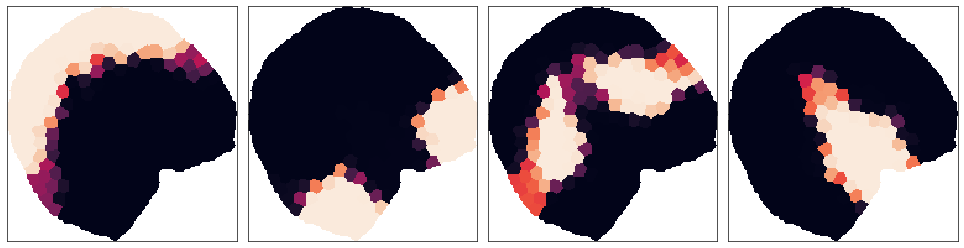

In [69]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

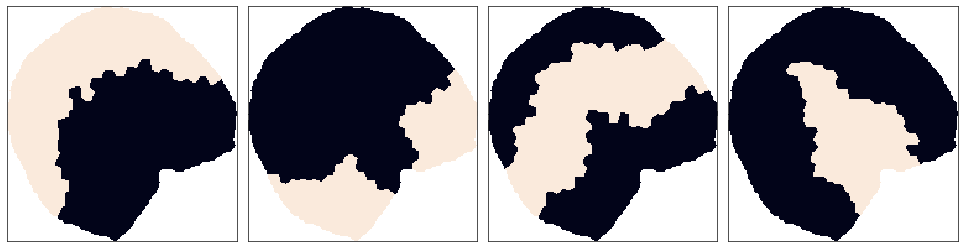

In [70]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

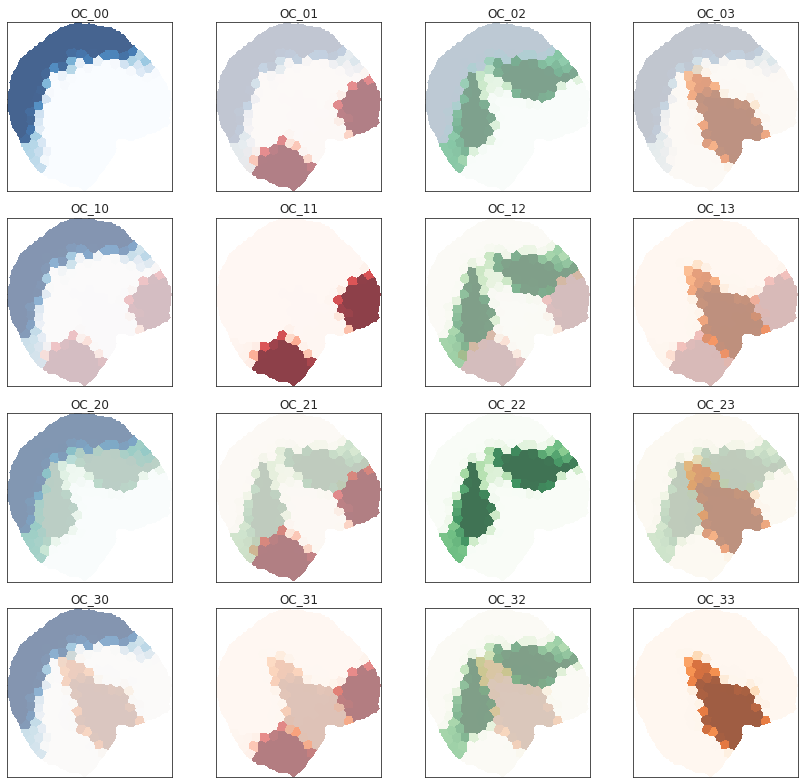

In [71]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

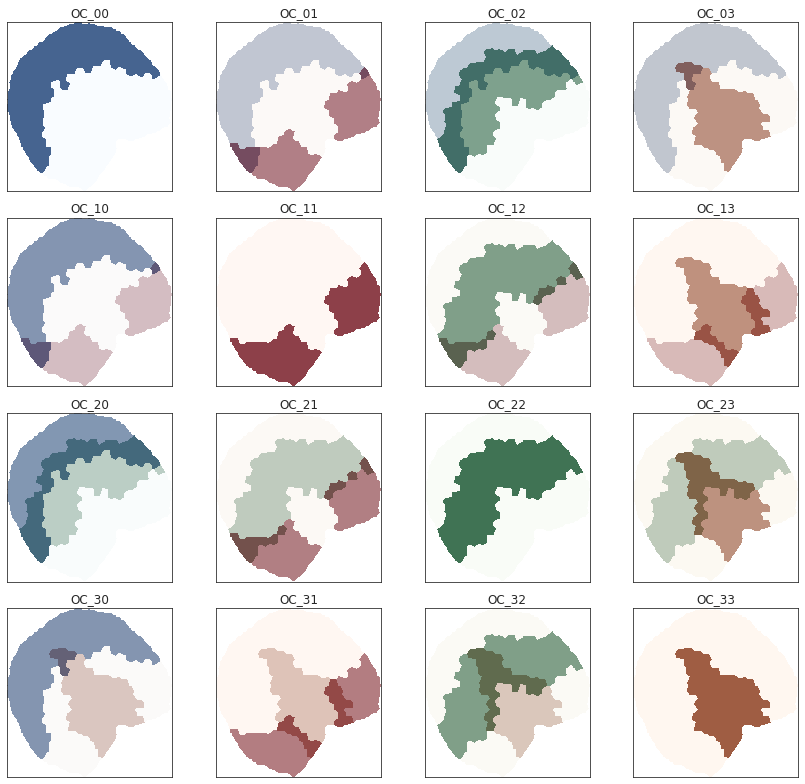

In [72]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

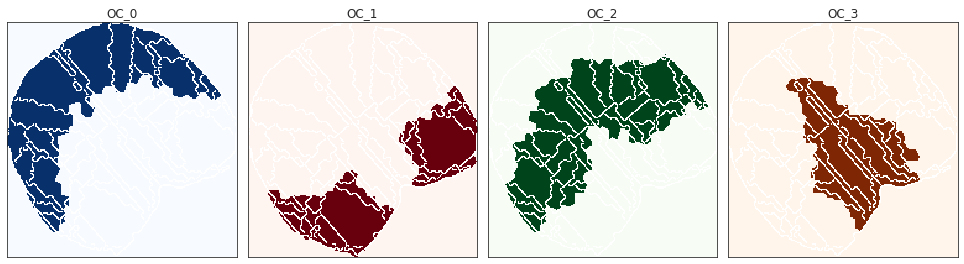

In [73]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [74]:
results_leiden_fixed = []

for result in tqdm(results_leiden[n_clusters], leave=False):
    b = np.ones_like(result.comm_mat) * -1
    for i in range(n_clusters):
        a = np.zeros_like(result.comm_mat)
        a[result.comm_mat == i] = 1
        cluster_idx = kmeans.predict(a.reshape(1, -1)).item()
        b[result.comm_mat == i] = cluster_idx
    results_leiden_fixed.append(b[np.newaxis, ...])
    
results_leiden_fixed = np.concatenate(results_leiden_fixed)
avg_leiden = results_leiden_fixed.mean(0)

results_leiden_fixed.shape, avg_leiden.shape

  0%|          | 0/9160 [00:00<?, ?it/s]

((9160, 190, 186), (190, 186))

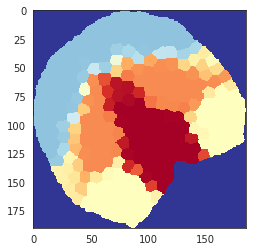

In [75]:
plt.imshow(avg_leiden, cmap='RdYlBu_r', interpolation='none')

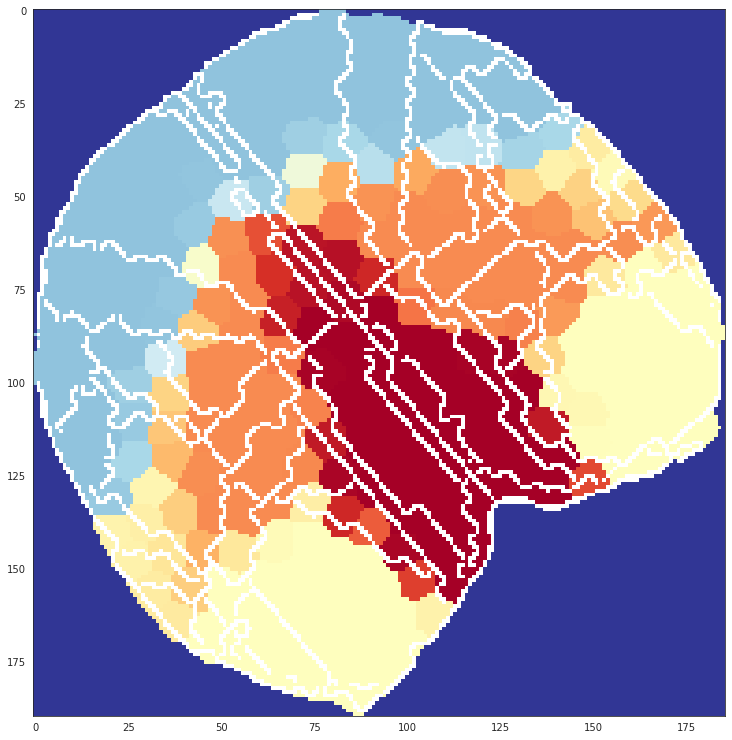

In [76]:
plt.figure(figsize=(15, 13))
plt.imshow(np.ma.masked_where(atls_org['contour'], avg_leiden), cmap='RdYlBu_r', interpolation='none')
plt.show()

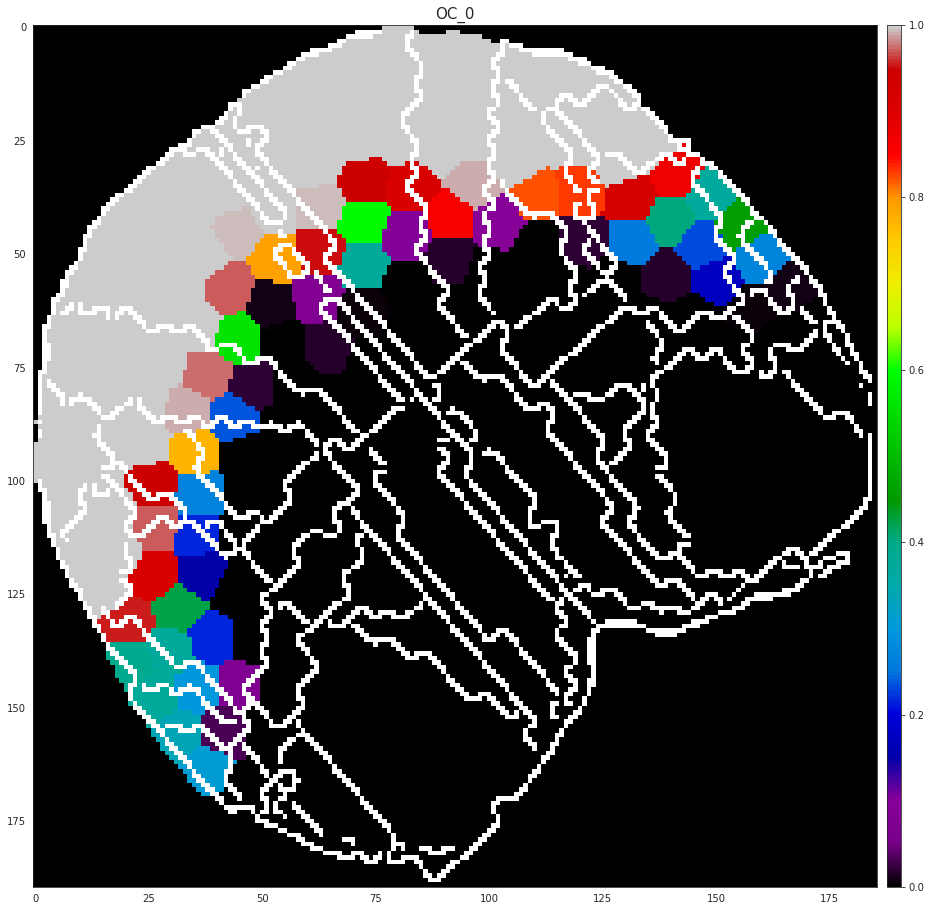

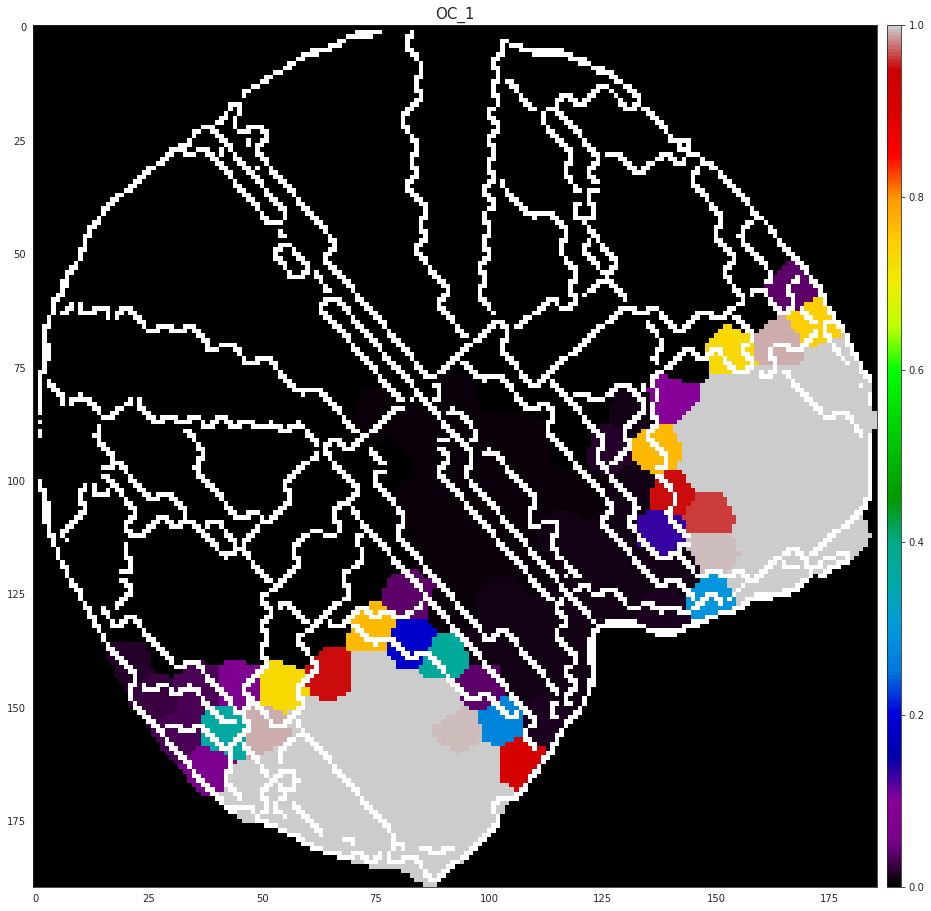

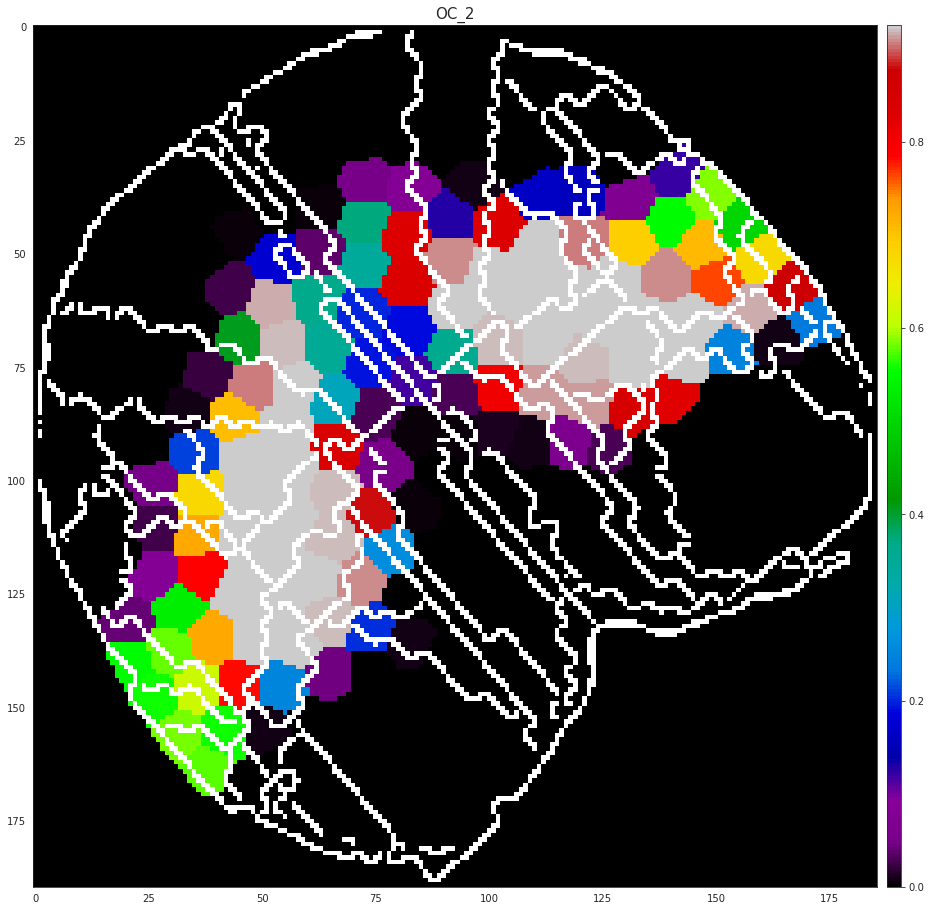

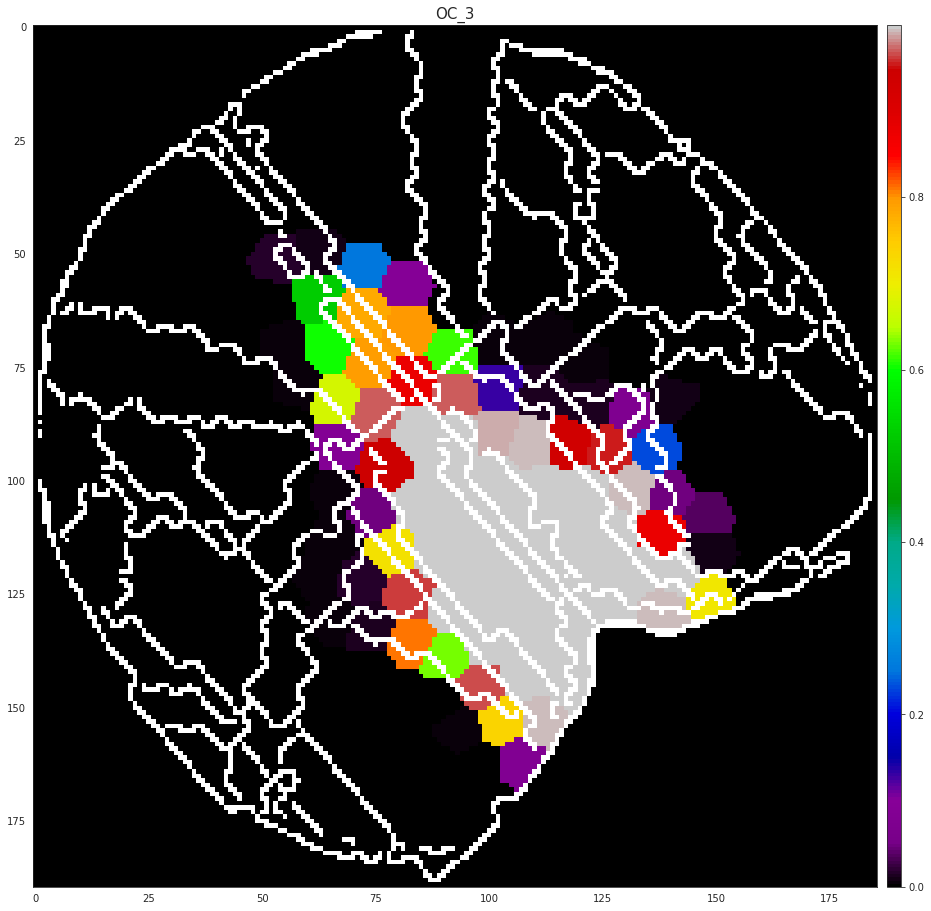

In [77]:
for i in range(n_clusters):
    plt.figure(figsize=(18, 17))
    c = clusters[i].reshape(load['atlas'].shape)
    plt.imshow(np.ma.masked_where(atls_org['contour'], c), cmap='nipy_spectral', interpolation='none')
    plt.colorbar(pad=0.01, shrink=0.933, aspect=60)
    plt.title('OC_{:d}'.format(i), fontsize=15)
    plt.show()

In [104]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        _proto = [item.reshape(1, -1) for item in result.comm_proto.values()]
        canonical_idxs = kmeans.predict(np.concatenate(_proto))
        reindexing = {i: key for i, key in enumerate(canonical_idxs)}
        canonical_partition = {node: reindexing[comm_idx] for node, comm_idx in result.partition.items()}
        nodes, canonical_comm_idxs = tuple(zip(*canonical_partition.items()))
        
        data_dict = {
            'num_comm': [k] * len(nodes),
            'node': nodes,
            'OC_idx': canonical_comm_idxs,
        }
        dict_list.append(data_dict)
        
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/9160 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [105]:
memberships = np.zeros((n_clusters, len(df.node.unique())))

for node in df.node.unique():
    selected_df = df.loc[df.node == node]
    for idx, num in collections.Counter(selected_df.OC_idx).most_common():
        memberships[idx, node] = num / len(selected_df)


node2roi = {node: load['atlas_kmeans'] == node_labels[node] for node in g.nodes}

cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

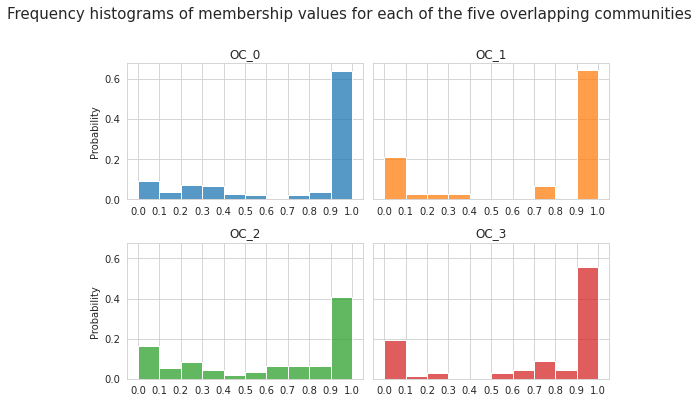

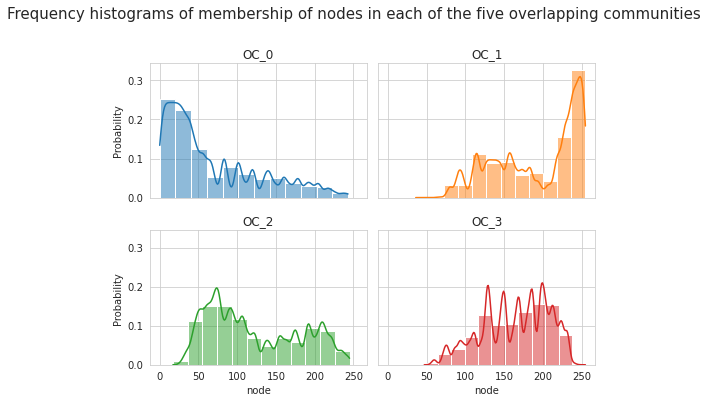

In [110]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(7.5, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//2, idx%2
    sns.histplot(
        memberships[idx][cluster_members[idx]],
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
    axes[i, j].set_xticks(bins)
msg = 'Frequency histograms of membership values for each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(7, 5.5), sharex='all', sharey='all')

for idx in df.OC_idx.unique():
    i, j = idx//2, idx%2
    selected_df = df.loc[df.OC_idx == idx]
    sns.histplot(
        data=selected_df,
        x='node',
        stat='probability',
        bins=12,
        color='C{:d}'.format(idx),
        kde=True,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

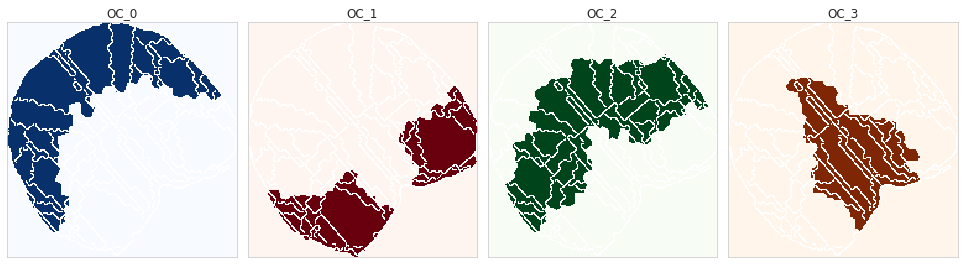

In [111]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

### Quantize (NMF)

In [82]:
from sklearn.decomposition import NMF

In [83]:
nmf = NMF(
    n_components=n_clusters,
    init='nndsvd',
    random_state=42,
)

In [84]:
nmf_pred = nmf.fit_transform(proto_all)

In [85]:
nmf.reconstruction_err_

4669.540302326946

In [86]:
from copy import deepcopy as dc

In [87]:
nmf_clusters = dc(nmf.components_)
nmf_clusters_binarized = dc(nmf.components_)
nmf_clusters_binarized[nmf_clusters_binarized <= 0.01] = 0
nmf_clusters_binarized[nmf_clusters_binarized > 0.01] = 1

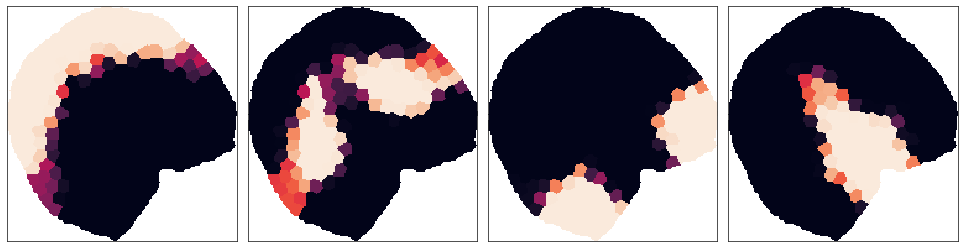

In [88]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

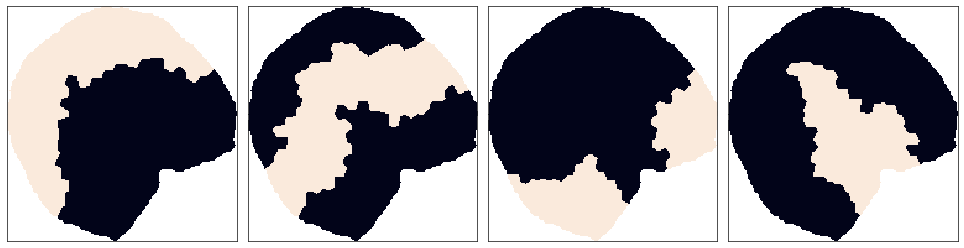

In [89]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

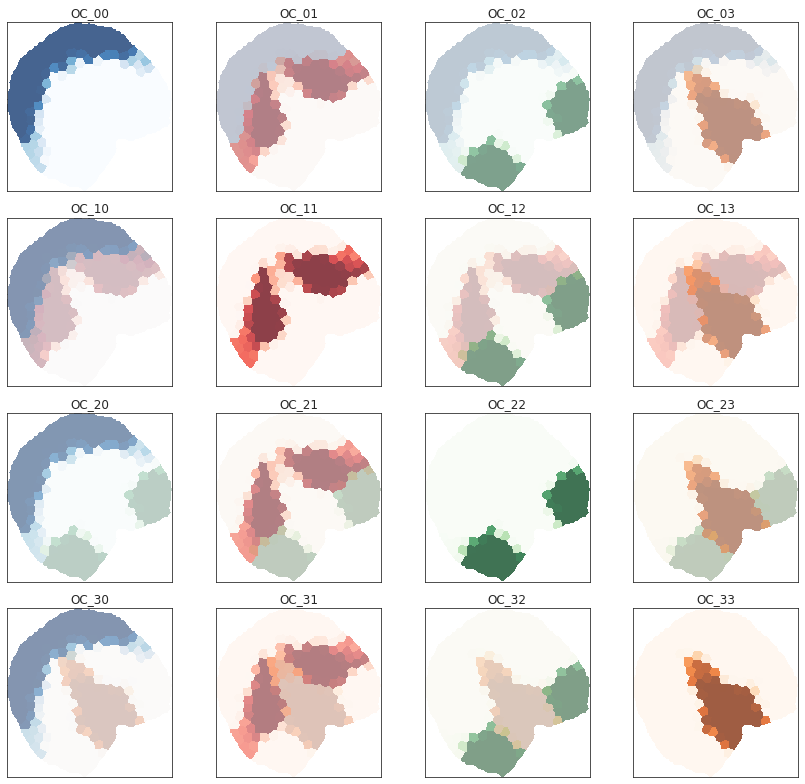

In [90]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

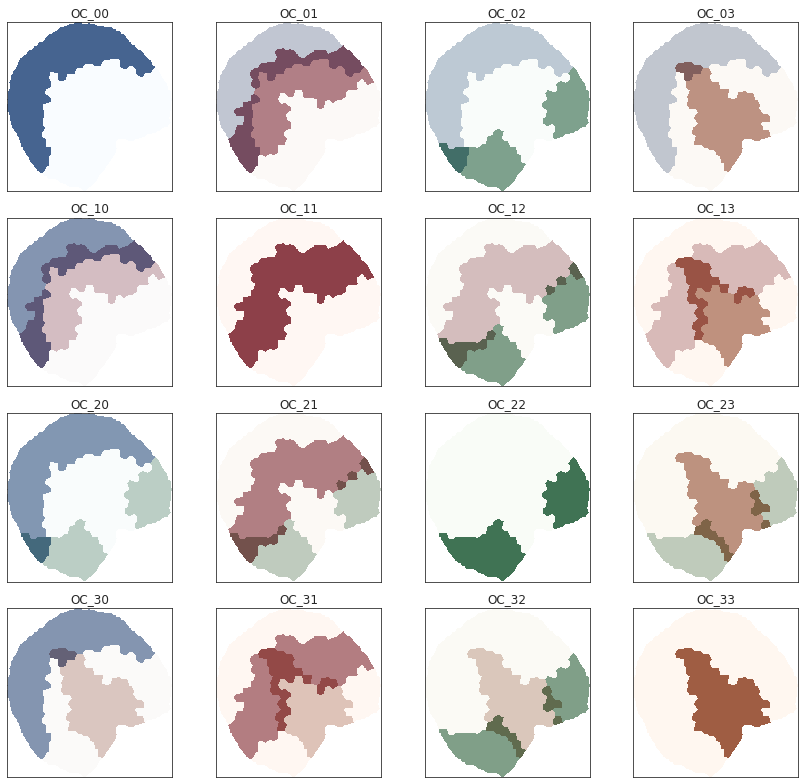

In [91]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

In [112]:
node2roi = {node: load['atlas_kmeans'] == node_labels[node] for node in g.nodes}
cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * nmf_clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

In [113]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        for proto_vec in result.comm_proto.values():
            pred = nmf.transform(proto_vec.reshape(1, -1))
            pred = pred.flatten()
            pred /= pred.sum()

            nodes_inside = list(itertools.compress(
                data=list(node2roi.keys()),
                selectors=[(roi*proto_vec.reshape(roi.shape)).sum() for roi in node2roi.values()]
            ))
            for node in nodes_inside:
                data_dict = {
                    'num_comm': [k] * len(pred),
                    'node': [node] * len(pred),
                    'OC_idx': range(len(pred)),
                    'membership': pred,
                }
                dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/9160 [00:00<?, ?it/s]

  0%|          | 0/779 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

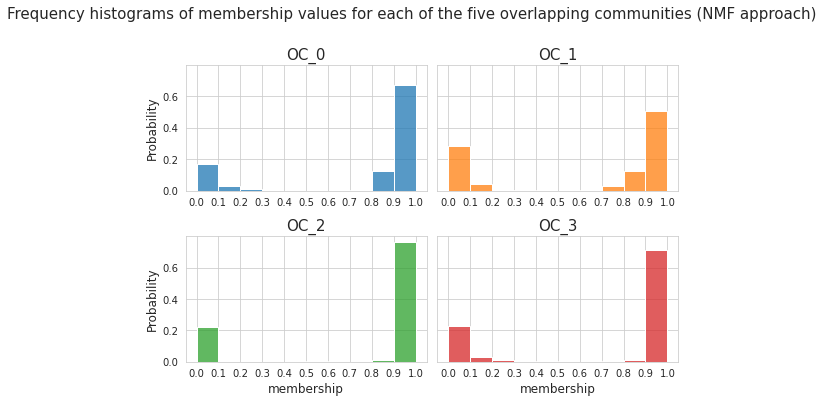

  0%|          | 0/4 [00:00<?, ?it/s]

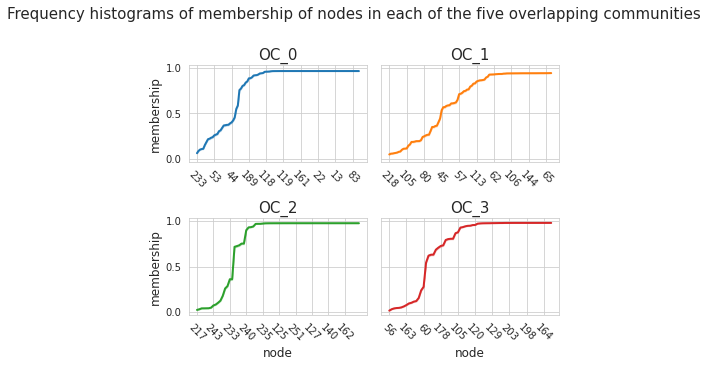

In [114]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(7.7, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//2, idx%2
    
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    sns.histplot(
        data=selected_df,
        x='membership',
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    axes[i, j].set_xticks(bins)
    
    axes[i, j].set_ylabel('Probability', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')

msg = 'Frequency histograms of membership values for each of the five overlapping communities (NMF approach)'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(6, 5), sharey='all')

num_ticks = 10
for idx in tqdm(df.OC_idx.unique(), leave=False):
    i, j = idx//2, idx%2
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    nodes_sorted = selected_df.groupby('node').mean().sort_values('membership').index.tolist()
    node_rank = {node: i for i, node in enumerate(nodes_sorted)}
    ranked_df = pd.concat([selected_df, pd.DataFrame(columns=['node_rank'])], axis=1)
    ranked_df.loc[:, 'node_rank'] = [node_rank[node] for node in ranked_df.node]

    sns.lineplot(
        data=ranked_df,
        x='node_rank',
        y='membership',
        color='C{:d}'.format(idx),
        lw=2,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    
    delta = int(np.ceil(len(node_rank) / num_ticks))
    xticks = range(0, len(node_rank), delta)
    xtick_labels = np.array(list(node_rank))[xticks]
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xtick_labels, rotation=-45)
    axes[i, j].set_ylabel('membership', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('node', fontsize=12)
    else:
        axes[i, j].set_xlabel('')

msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

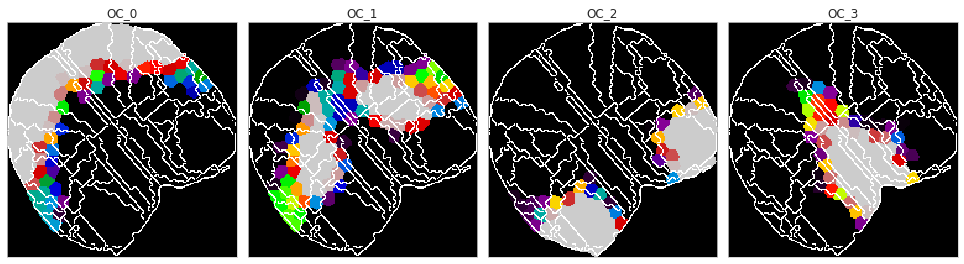

In [115]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap='nipy_spectral')
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [112]:
a = nmf.inverse_transform(pred)
a = a.reshape(-1, *load['atlas'].shape)
a.shape

(4, 190, 186)

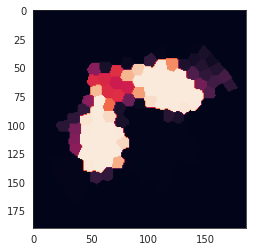

In [114]:
plt.imshow(a[2])

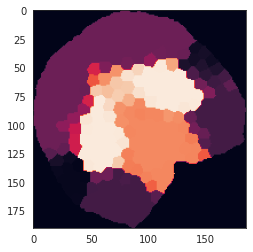

In [78]:
a = nmf.inverse_transform([0.4, 1, 0.25, 1, 0])
plt.imshow(a.reshape(load['atlas'].shape))

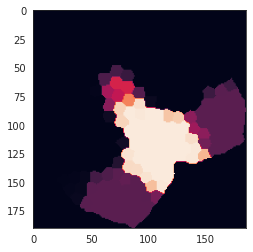

In [79]:
a = nmf.inverse_transform([0, 0, 0.25, 1, 0])
plt.imshow(a.reshape(load['atlas'].shape))

### Reflect, interpret the results, then run using:

- a) another threshold
- b) using Allen

### ---
---
---

## Same analysis, but using Allen parcellation

In [116]:
data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    data_all[run] = _load
    
    # normalize
    mean = np.mean([item.mean() for item in _load['ca'].values()])
    sd = np.mean([item.std() for item in _load['ca'].values()])
    _ca = {k: (v - mean) / sd for k, v in _load['ca'].items()}
    _df = pd.DataFrame.from_dict(_ca)
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

2             3             4             5             6    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.016470     -0.018240     -0.015282     -0.003259      0.018897   
std        0.629801      0.466723      0.633126      1.220131      1.269930   
min       -2.448160     -1.950162     -2.127644     -4.117877     -4.076775   
25%       -0.428421     -0.314127     -0.452591     -0.845619     -0.833966   
50%       -0.013142     -0.018966     -0.032826     -0.029985     -0.019495   
75%        0.394903      0.269910      0.394358      0.798206      0.849160   
max        3.802673      3.315142      3.156683      6.369267      7.755381   

                7             8             9             10            11   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.016037     -0.006291      0.048155     -0.008254     -0.008132   
std        0.422778      0.965836      1.928495      1.074744      0.832809   
min       -1.576220     -3.272419     -5.927036     -3.740386     -2.652617   
25%       -0.302064     -0.657687     -1.265214     -0.746149     -0.587083   
50%       -0.023853     -0.025799     -0.030234     -0.033669     -0.029572   
75%        0.258890      0.634490      1.285492      0.703723      0.531091   
max        1.860840      4.785238     10.427175      5.674547      4.721781   

       ...           525           526           528           530  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.034107     -0.016903     -0.004136     -0.017237   
std    ...      0.504141      1.087339      0.399043      0.179432   
min    ...     -1.935170     -3.434844     -1.546170     -0.726891   
25%    ...     -0.369868     -0.762635     -0.247245     -0.137745   
50%    ...     -0.033002     -0.035239     -0.019736     -0.017527   
75%    ...      0.291316      0.696168      0.213845      0.094695   
max    ...      2.633923      5.843461      5.597064      1.116010   

                538           539           540           541           655  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.028251      0.064408      0.062204     -0.034549      0.025482   
std        1.688213      2.205852      1.665477      0.457557      0.849909   
min       -6.097915     -7.547431     -7.089397     -1.765626     -3.180276   
25%       -0.986188     -1.292455     -0.975689     -0.338368     -0.521417   
50%        0.096717      0.158215      0.079588     -0.030011      0.022124   
75%        1.122999      1.448869      1.011084      0.264375      0.525521   
max       12.347784     16.508649     19.975790      2.203298     11.461152   

                656  
count  22000.000000  
mean      -0.015245  
std        0.637300  
min       -2.387982  
25%       -0.421664  
50%       -0.026428  
75%        0.365549  
max        6.242416  

[8 rows x 61 columns]

In [117]:
thresholds = [0.77, 0.78, 0.80, 0.81, 0.82, 0.83, 0.84]
corrs = get_corrs(df, thresholds=thresholds)

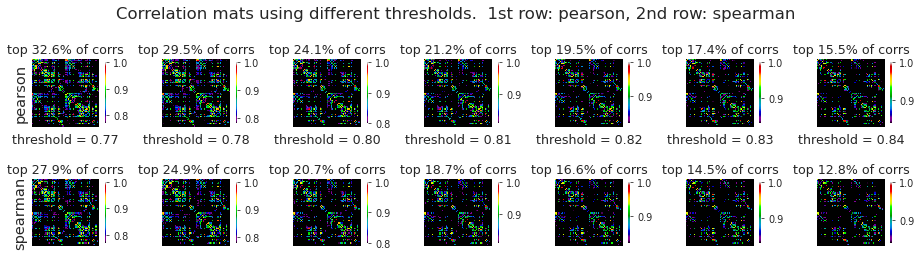

In [118]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

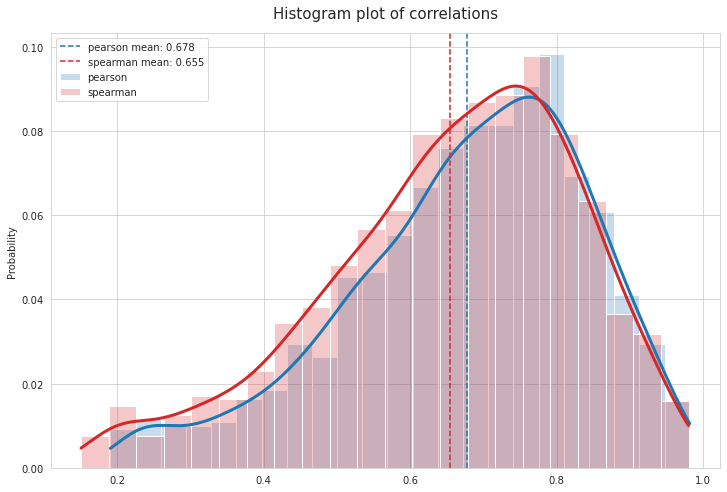

In [119]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [120]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [121]:
results_louvain = run_louvain(graphs[0.83], res=np.logspace(-0.3, 0.3, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

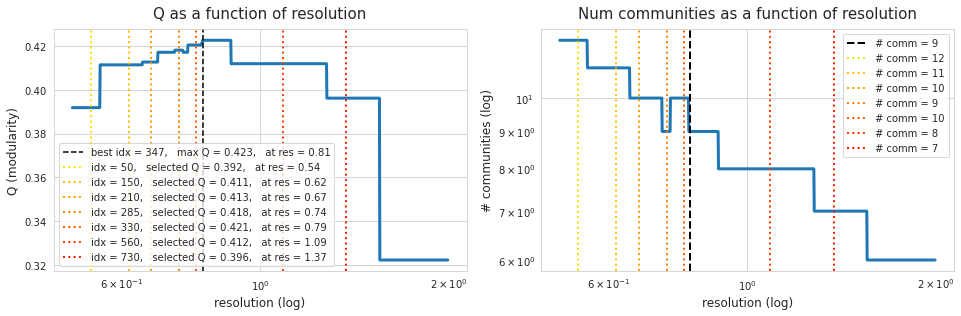

In [134]:
selected_idxs = [50, 150, 210, 285, 330, 560, 730]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

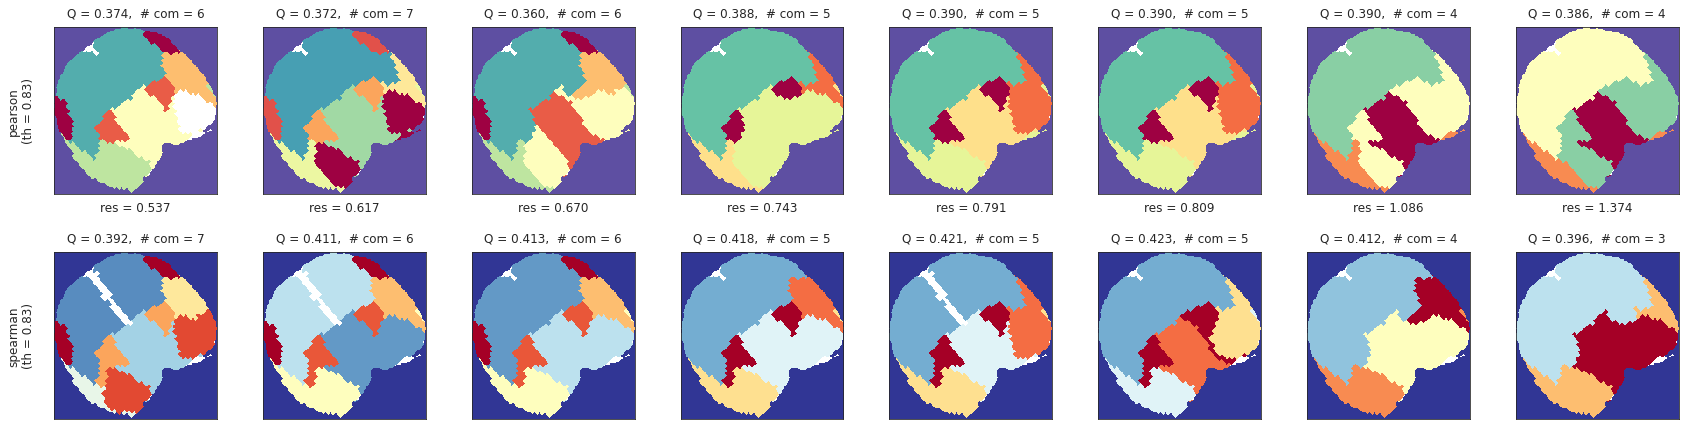

In [138]:
# selected_idxs = [450, 540, 585, 680] # [440, 520, 530, 590]

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.83,
    figsize=(24, 6),
    colorbar=False, )

#### Leiden

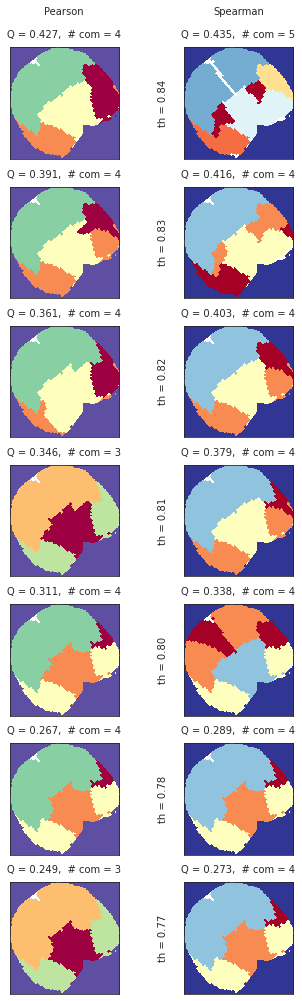

In [140]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    figsize=None,
    colorbar=False,
)

### The other approach

In [144]:
th = 0.82
n = 2000
g = nx.from_numpy_matrix(corrs['spearman'][th])

# get results
results_leiden = defaultdict(list)
for i in tqdm(range(n)):
    coms = cdlib_algorithms.leiden(g, weights='weight')
    community_list = sorted(coms.communities, key=lambda x: len(x), reverse=True)
    partition = convert('community', 'partition', community=community_list)
    output = filter_islands(partition, load['atlas'], node_labels, min_com_size=3)
    q = nx_comm.modularity(g, communities=community_list)
    num_comm = len(set(partition.values()))

    comm_proto = {}
    for j in range(num_comm):
        a = np.zeros_like(output['comm_mat'])
        a[output['comm_mat'] == j] = 1
        comm_proto[j] = a.flatten()

    results = Leiden(
        idx=i,
        num_comm=num_comm,
        modularity=q,
        partition=partition,
        comm_mat=output['comm_mat'],
        comm_proto=comm_proto,
    )
    results_leiden[num_comm].append(results)

results_leiden = dict(results_leiden)
results_leiden = dict(sorted(results_leiden.items(), key=lambda x: len(x[1]), reverse=True))


# get modularity values
q_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        q_leiden[k].append(result.modularity)
q_leiden = dict(q_leiden)


# get prototypes
proto_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        for proto in result.comm_proto.values():
            proto_leiden[k].append(proto)
proto_leiden = dict(proto_leiden)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [145]:
{k: len(v) for k, v in results_leiden.items()}

{7: 1491, 8: 461, 9: 47, 6: 1}

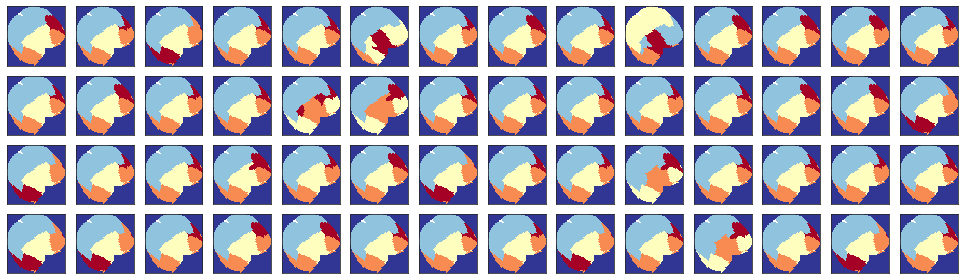

In [146]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[0]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

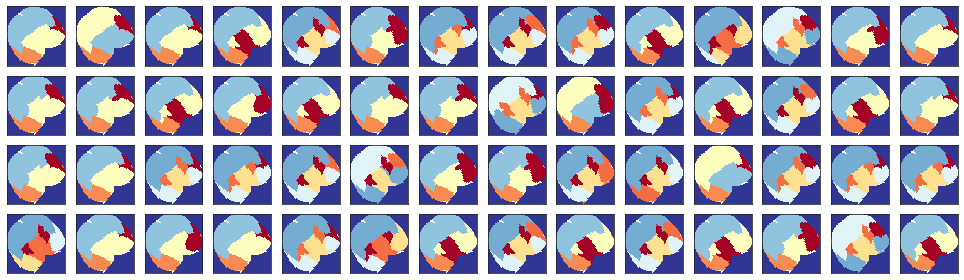

In [147]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[1]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

...merging dicts: 0it [00:00, ?it/s]

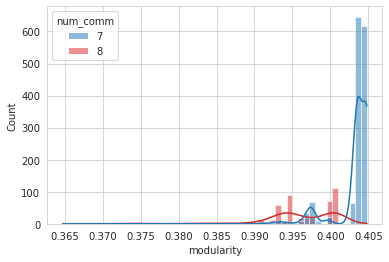

In [148]:
dict_list = []

for k, v in q_leiden.items():
    if len(v) < n / 20:
        continue
    dict_list.append({'num_comm': [k] * len(v), 'modularity': v})

sns.set_style('whitegrid')
sns.histplot(
    data=pd.DataFrame.from_dict(merge_dicts(dict_list)),
    x='modularity',
    hue='num_comm',
    palette=['C0', 'C3'],
    kde=True,
)
plt.show()

In [149]:
proto_all = [x.reshape(1, -1) for item in proto_leiden.values() for x in item]
proto_all = np.concatenate(proto_all)
proto_all.shape

(14554, 35340)

In [150]:
n_clusters = list(results_leiden.keys())[0]

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
).fit(proto_all)

In [151]:
# from sklearn.preprocessing import normalize as sk_normalize
from copy import deepcopy as dc

In [152]:
clusters = dc(kmeans.cluster_centers_)
clusters_binarized = dc(kmeans.cluster_centers_)
clusters_binarized
clusters_binarized[clusters_binarized <= 0.01] = 0
clusters_binarized[clusters_binarized > 0.01] = 1

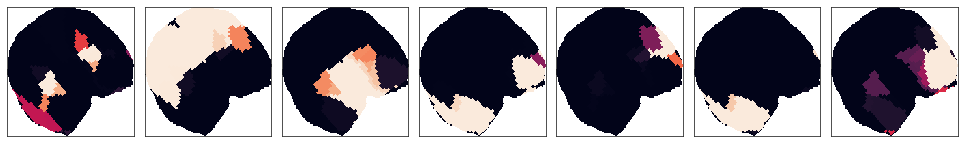

In [153]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

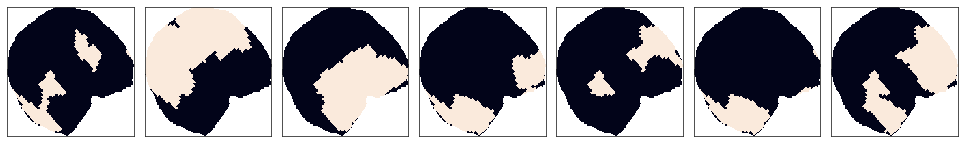

In [154]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

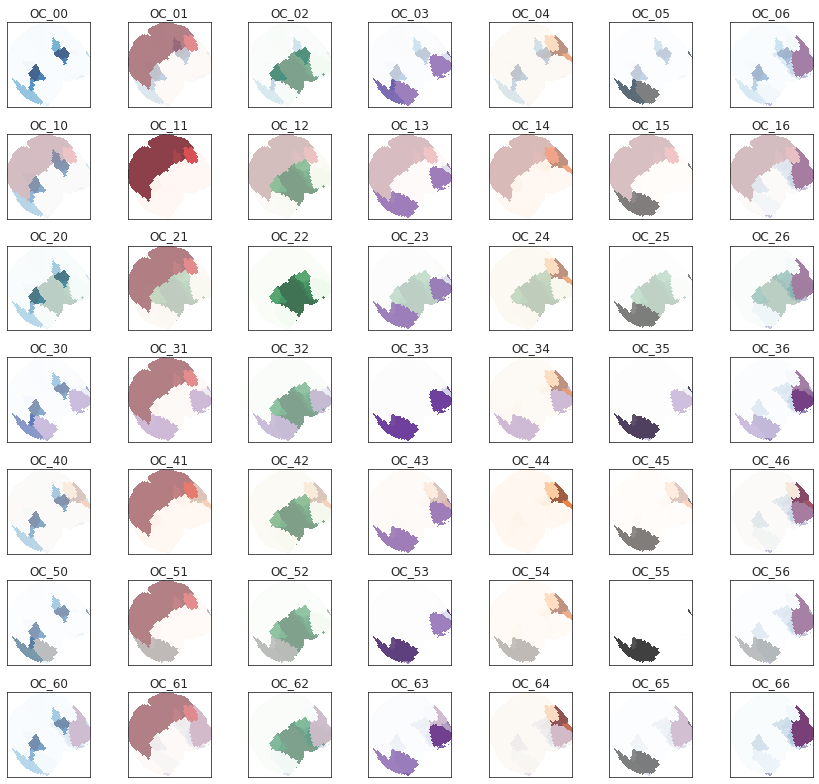

In [158]:
cmaps = {
    0: 'Blues',
    1: 'Reds',
    2: 'Greens',
    3: 'Purples',
    4: 'Oranges',
    5: 'Greys',
    6: 'BuPu',
}


fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

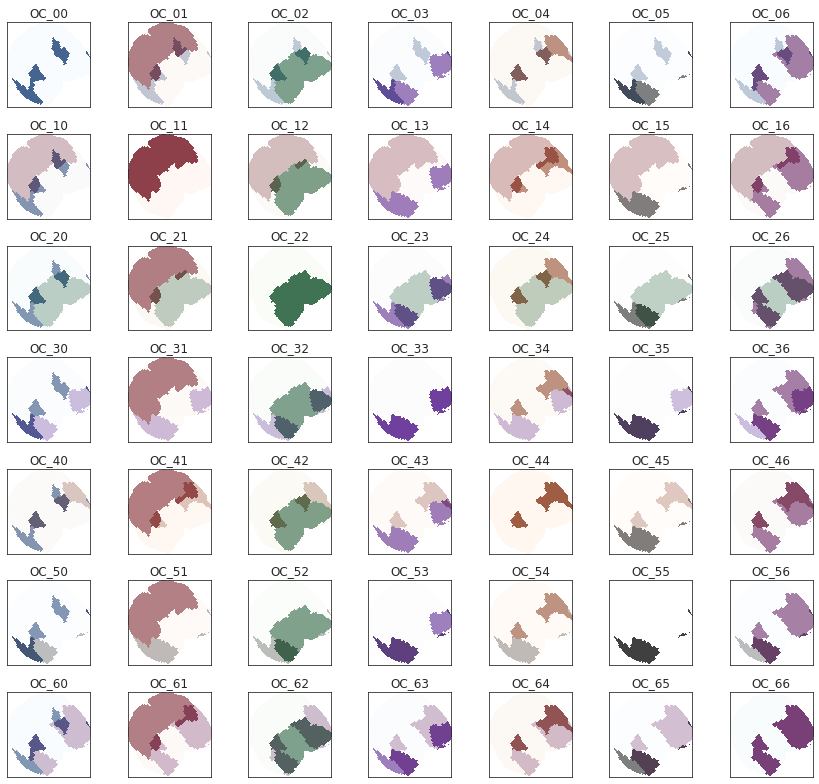

In [159]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

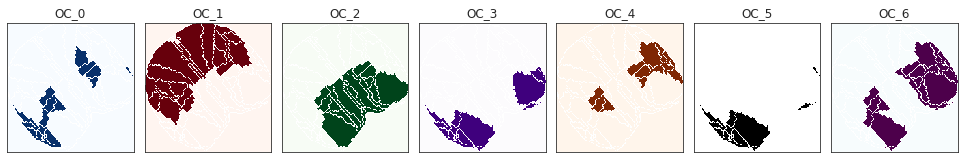

In [160]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [161]:
results_leiden_fixed = []

for result in tqdm(results_leiden[n_clusters], leave=False):
    b = np.ones_like(result.comm_mat) * -1
    for i in range(n_clusters):
        a = np.zeros_like(result.comm_mat)
        a[result.comm_mat == i] = 1
        cluster_idx = kmeans.predict(a.reshape(1, -1)).item()
        b[result.comm_mat == i] = cluster_idx
    results_leiden_fixed.append(b[np.newaxis, ...])
    
results_leiden_fixed = np.concatenate(results_leiden_fixed)
avg_leiden = results_leiden_fixed.mean(0)

results_leiden_fixed.shape, avg_leiden.shape

  0%|          | 0/1491 [00:00<?, ?it/s]

((1491, 190, 186), (190, 186))

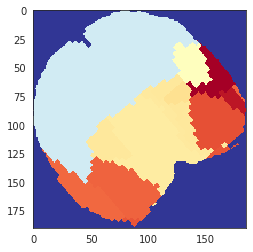

In [162]:
plt.imshow(avg_leiden, cmap='RdYlBu_r', interpolation='none')

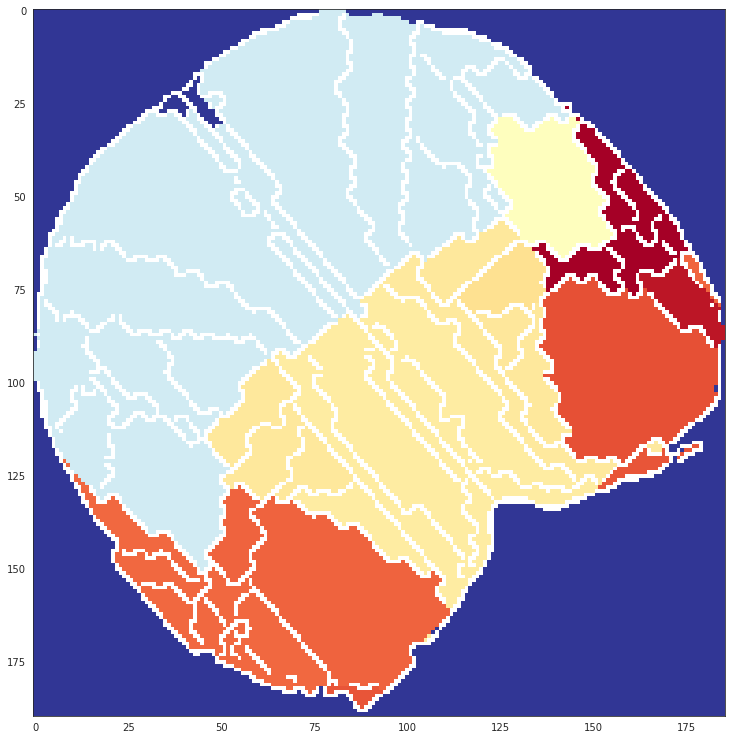

In [163]:
plt.figure(figsize=(15, 13))
plt.imshow(np.ma.masked_where(atls_org['contour'], avg_leiden), cmap='RdYlBu_r', interpolation='none')
plt.show()

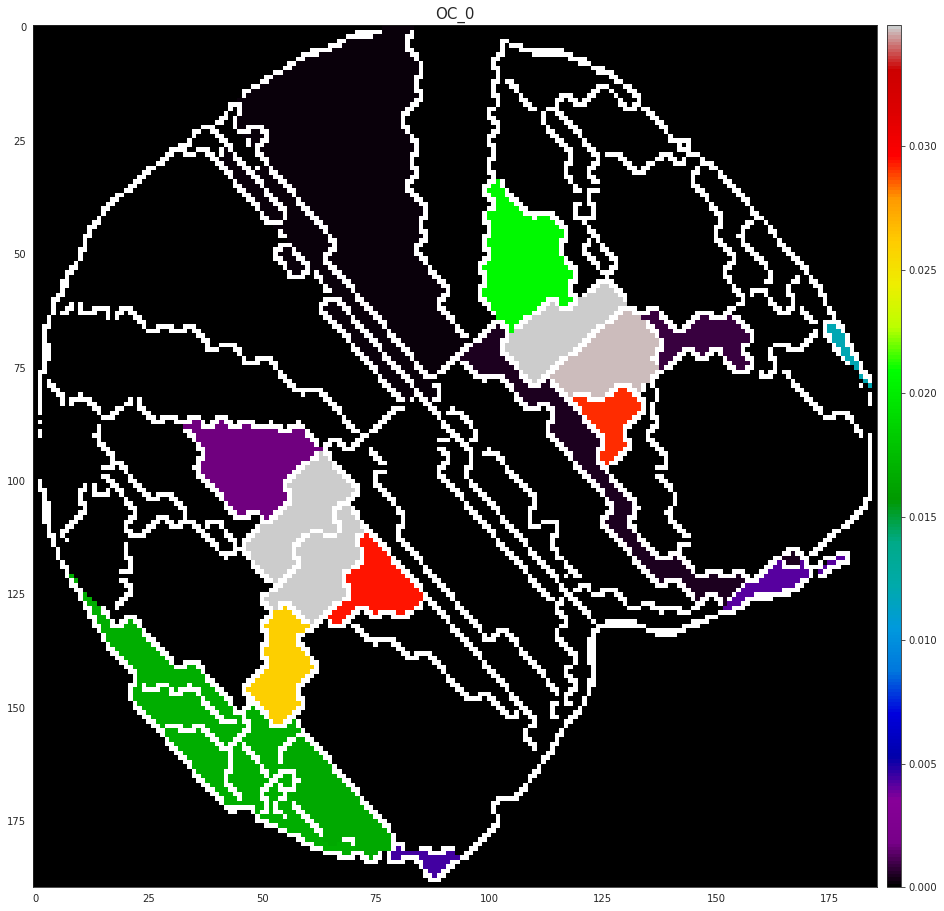

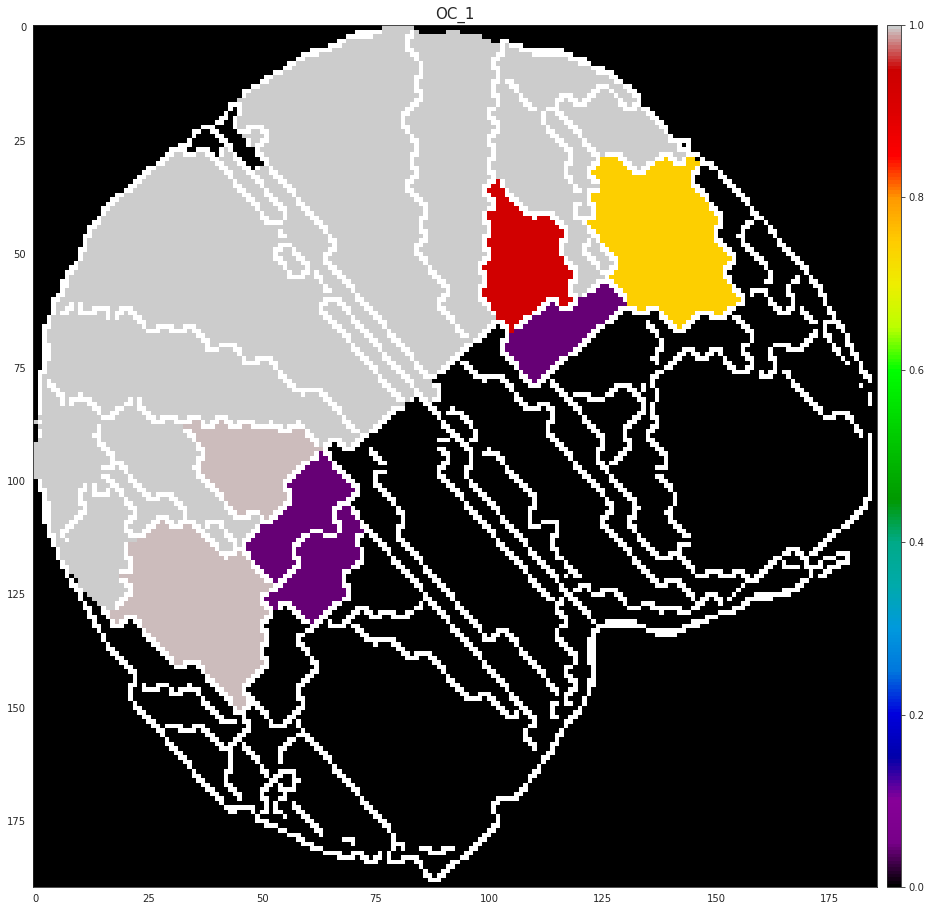

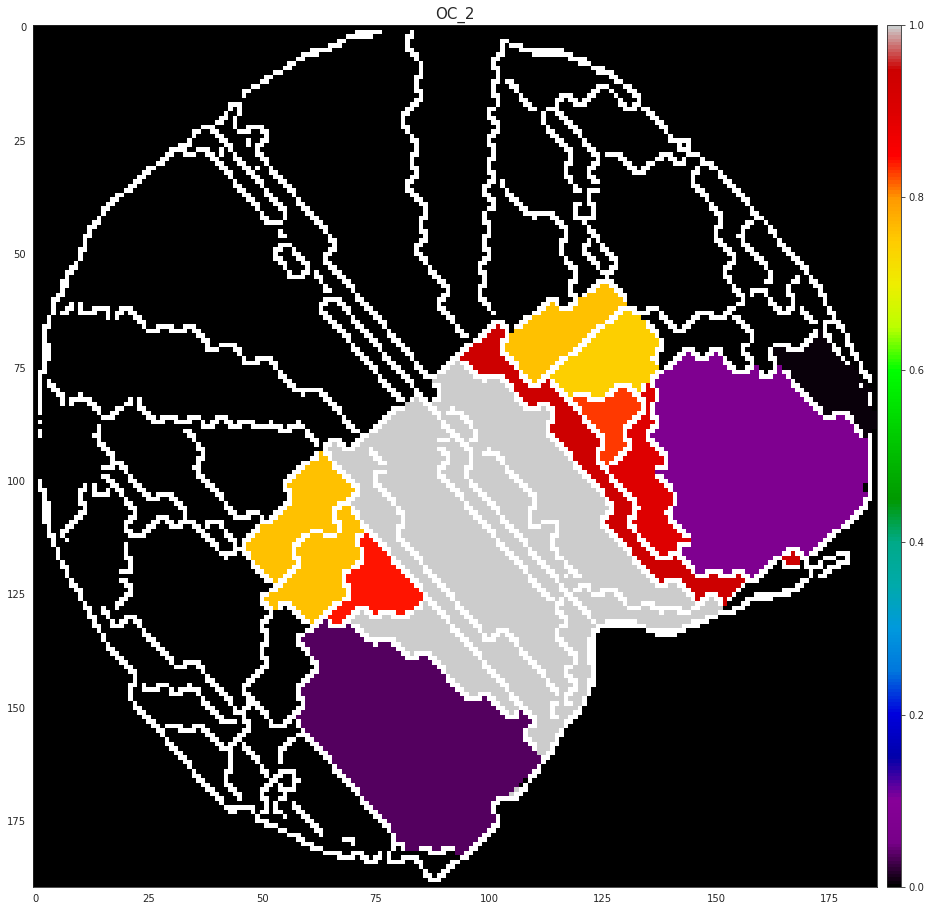

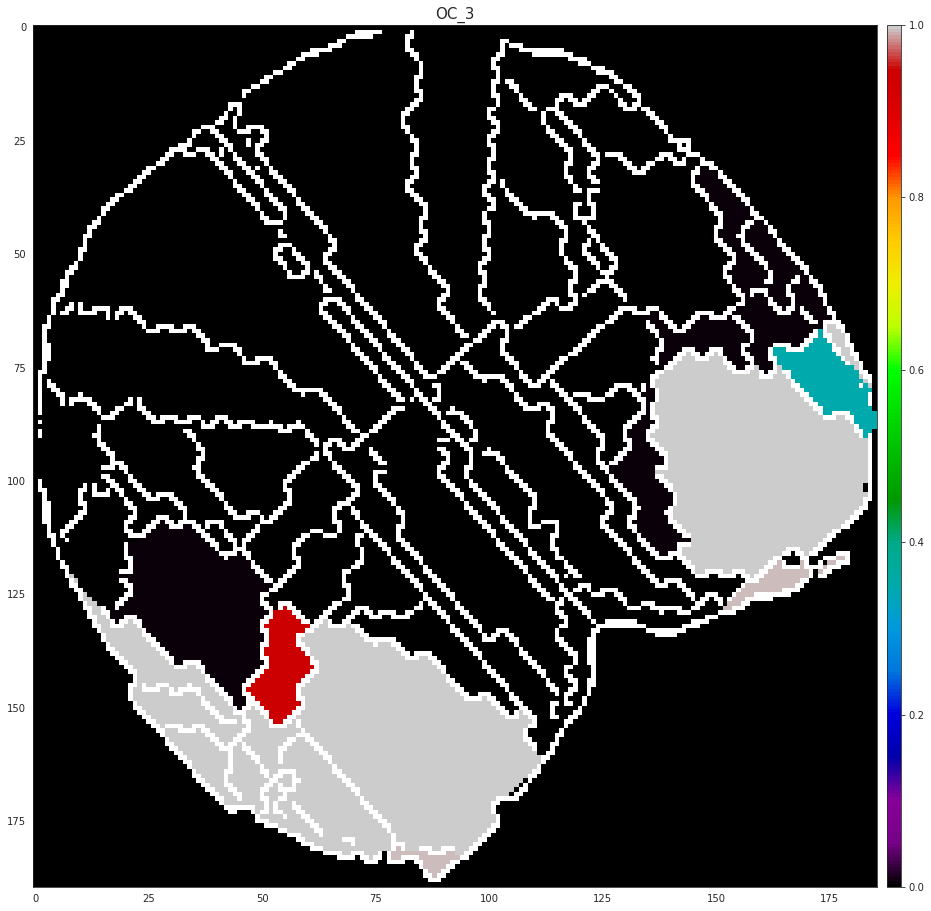

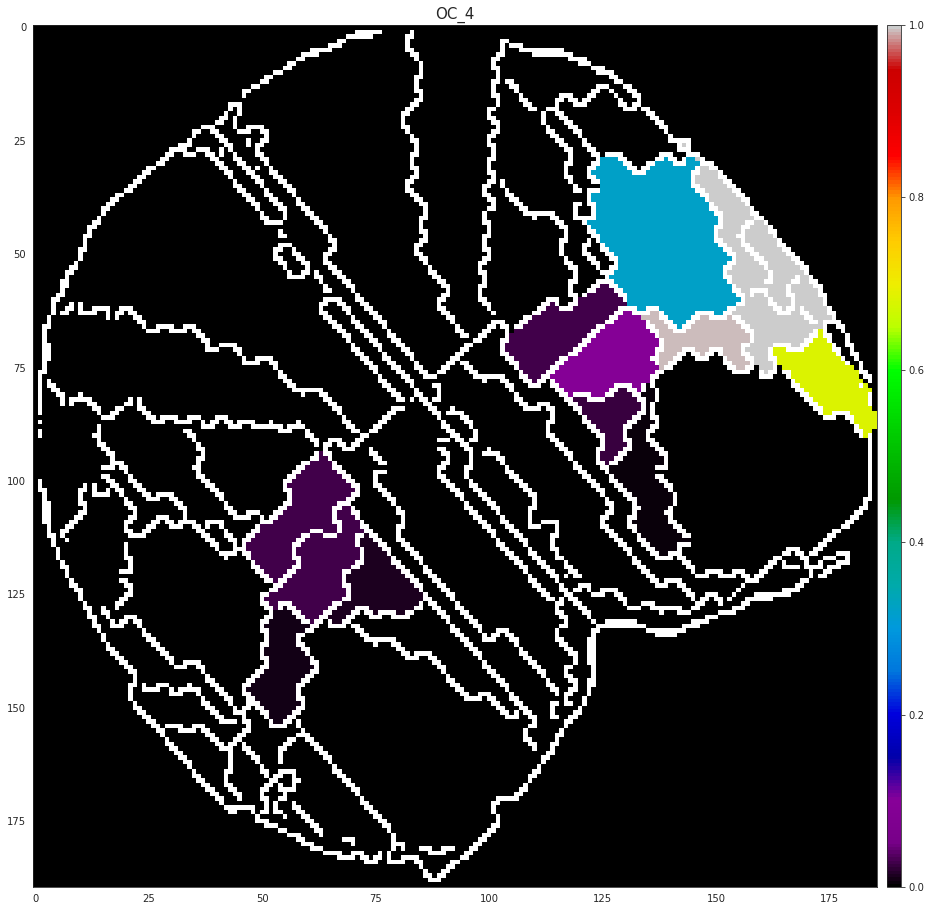

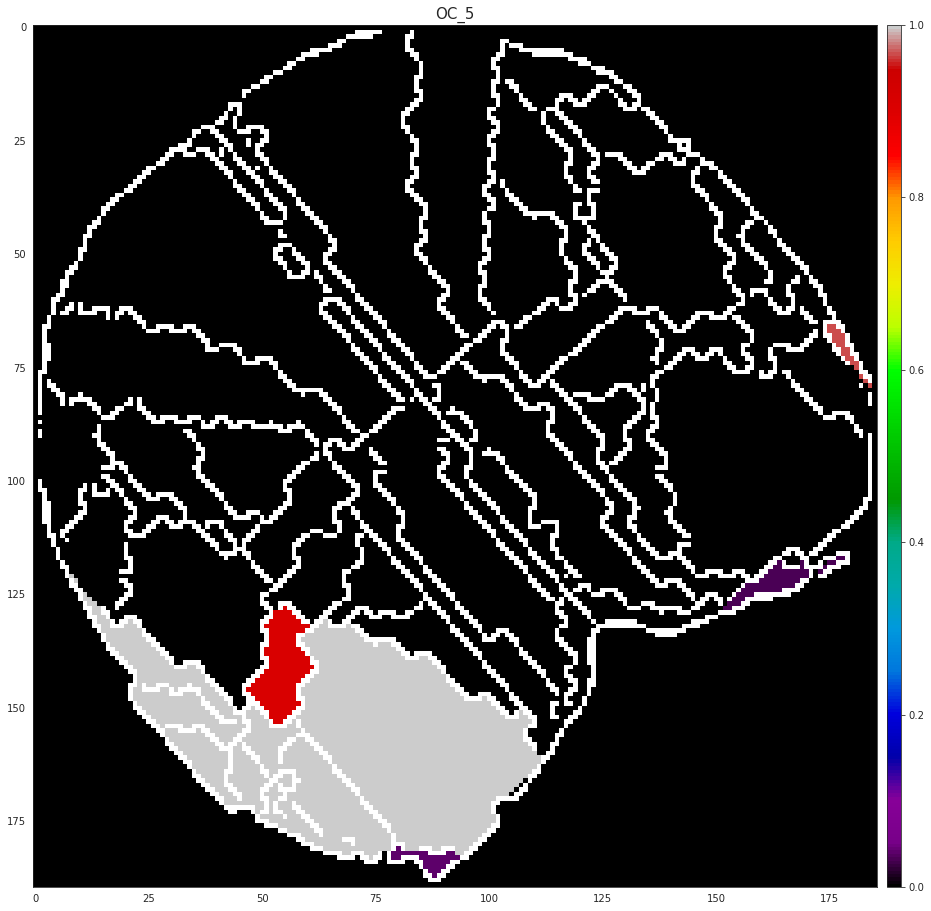

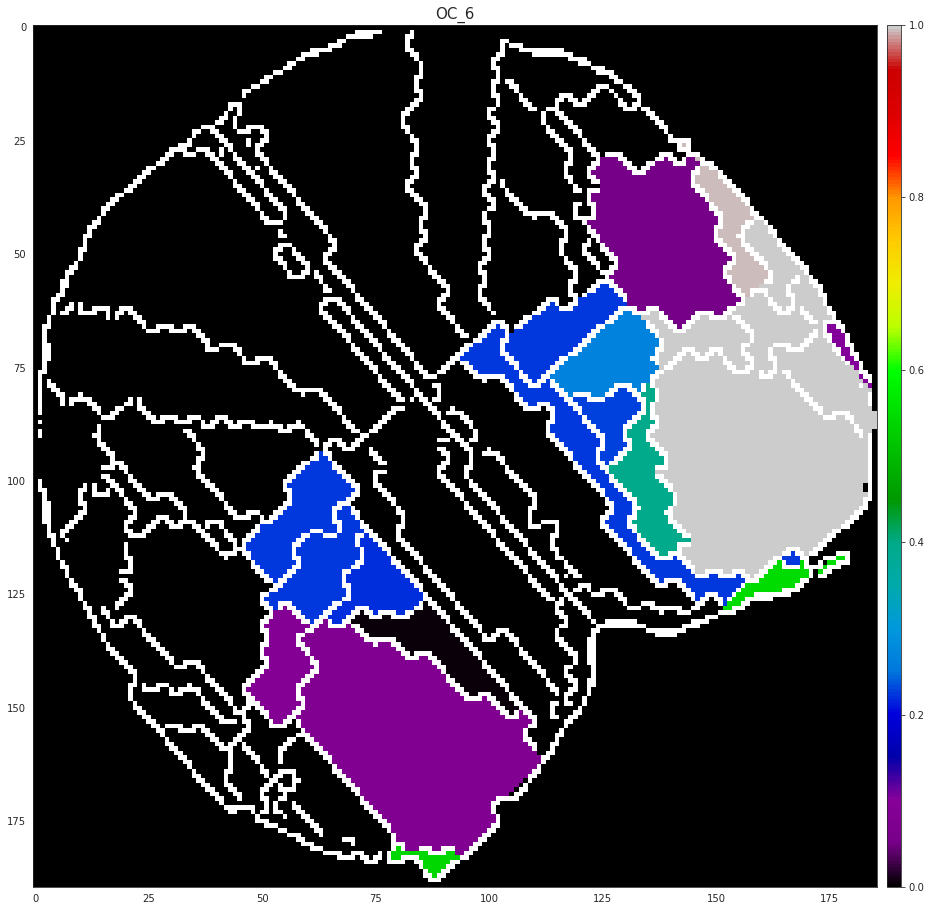

In [164]:
for i in range(n_clusters):
    plt.figure(figsize=(18, 17))
    c = clusters[i].reshape(load['atlas'].shape)
    plt.imshow(np.ma.masked_where(atls_org['contour'], c), cmap='nipy_spectral', interpolation='none')
    plt.colorbar(pad=0.01, shrink=0.933, aspect=60)
    plt.title('OC_{:d}'.format(i), fontsize=15)
    plt.show()

In [165]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        _proto = [item.reshape(1, -1) for item in result.comm_proto.values()]
        canonical_idxs = kmeans.predict(np.concatenate(_proto))
        reindexing = {i: key for i, key in enumerate(canonical_idxs)}
        canonical_partition = {node: reindexing[comm_idx] for node, comm_idx in result.partition.items()}
        nodes, canonical_comm_idxs = tuple(zip(*canonical_partition.items()))
        
        data_dict = {
            'num_comm': [k] * len(nodes),
            'node': nodes,
            'OC_idx': canonical_comm_idxs,
        }
        dict_list.append(data_dict)
        
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1491 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [172]:
memberships = np.zeros((n_clusters, len(df.node.unique())))

for node in df.node.unique():
    selected_df = df.loc[df.node == node]
    for idx, num in collections.Counter(selected_df.OC_idx).most_common():
        memberships[idx, node] = num / len(selected_df)


node2roi = {node: load['atlas'] == node_labels[node] for node in g.nodes}

cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

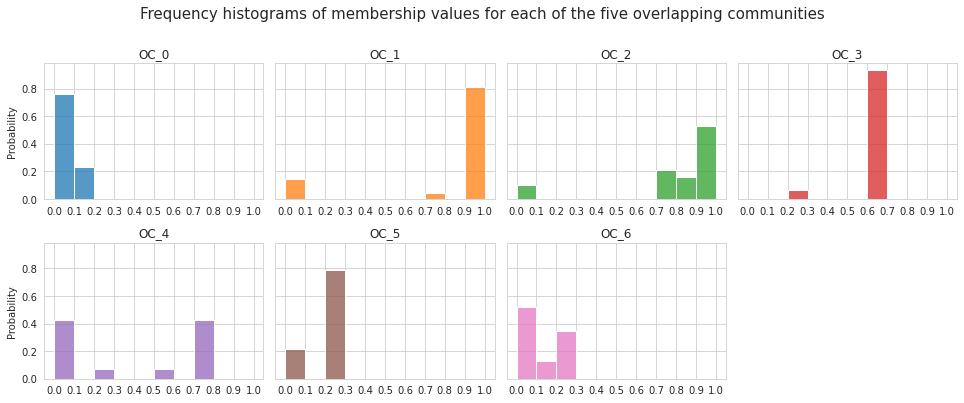

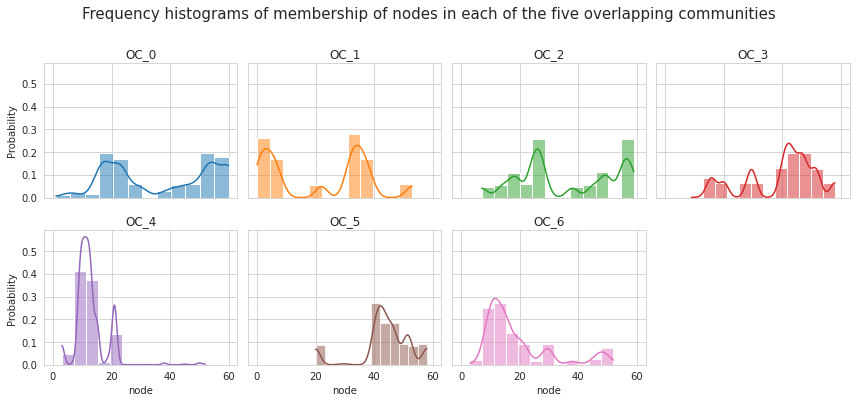

In [173]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    sns.histplot(
        memberships[idx][cluster_members[idx]],
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
    axes[i, j].set_xticks(bins)
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(12, 5.5), sharex='all', sharey='all')

for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    selected_df = df.loc[df.OC_idx == idx]
    sns.histplot(
        data=selected_df,
        x='node',
        stat='probability',
        bins=12,
        color='C{:d}'.format(idx),
        kde=True,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

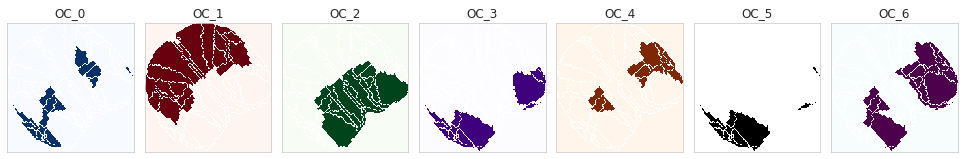

In [175]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

### NMF?

In [176]:
from sklearn.decomposition import NMF

In [177]:
nmf = NMF(
    n_components=n_clusters,
    init='nndsvd',
    random_state=42,
)

In [178]:
nmf_pred = nmf.fit_transform(proto_all)

In [179]:
nmf.reconstruction_err_

915.9600807033803

In [180]:
from copy import deepcopy as dc

In [181]:
nmf_clusters = dc(nmf.components_)
nmf_clusters_binarized = dc(nmf.components_)
nmf_clusters_binarized[nmf_clusters_binarized <= 0.01] = 0
nmf_clusters_binarized[nmf_clusters_binarized > 0.01] = 1

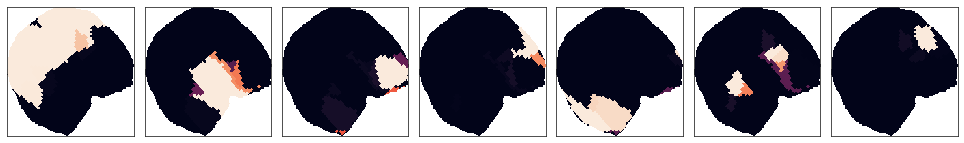

In [182]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

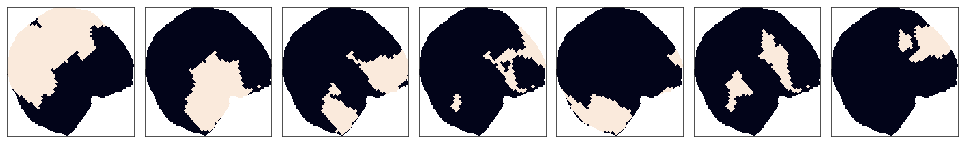

In [183]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

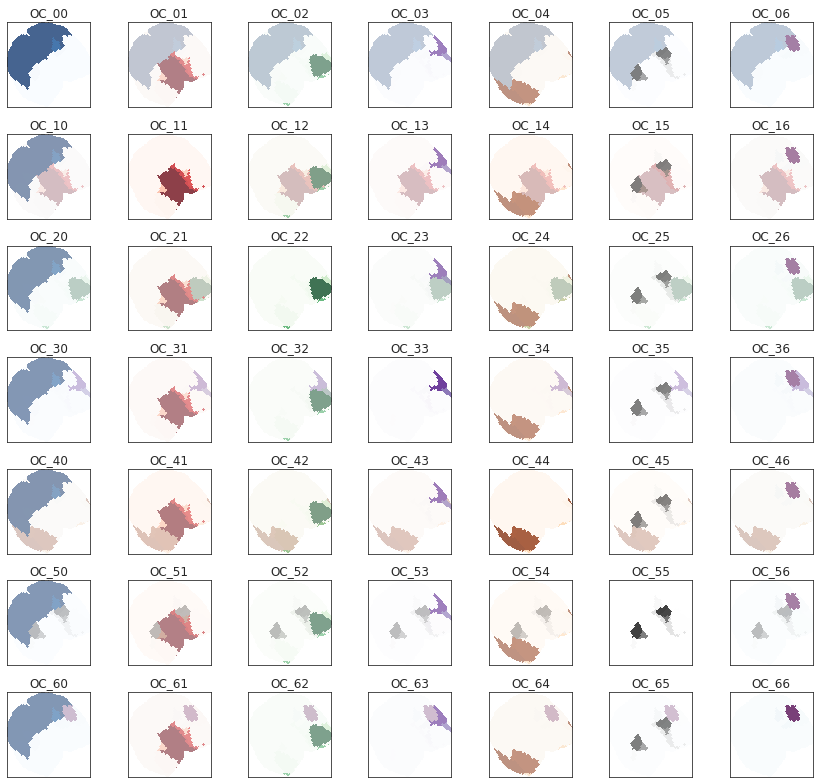

In [184]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

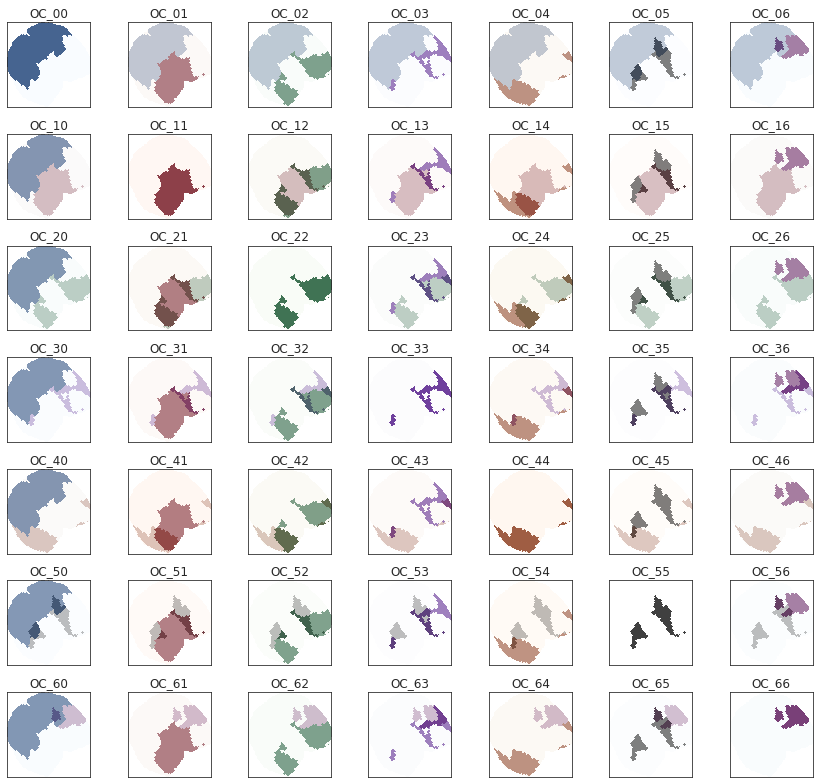

In [185]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

In [186]:
node2roi = {node: load['atlas'] == node_labels[node] for node in g.nodes}
cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * nmf_clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

In [188]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        for proto_vec in result.comm_proto.values():
            pred = nmf.transform(proto_vec.reshape(1, -1))
            pred = pred.flatten()
            if pred.sum() > 0:
                pred /= pred.sum()

            nodes_inside = list(itertools.compress(
                data=list(node2roi.keys()),
                selectors=[(roi*proto_vec.reshape(roi.shape)).sum() for roi in node2roi.values()]
            ))
            for node in nodes_inside:
                data_dict = {
                    'num_comm': [k] * len(pred),
                    'node': [node] * len(pred),
                    'OC_idx': range(len(pred)),
                    'membership': pred,
                }
                dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1491 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

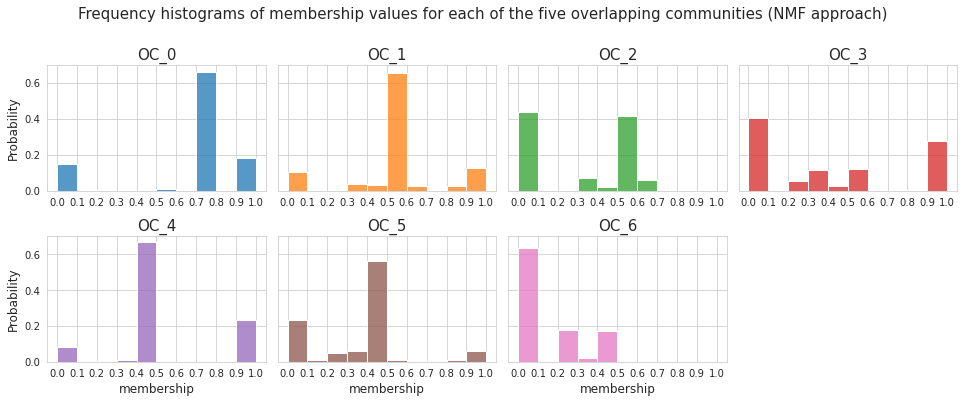

  0%|          | 0/7 [00:00<?, ?it/s]

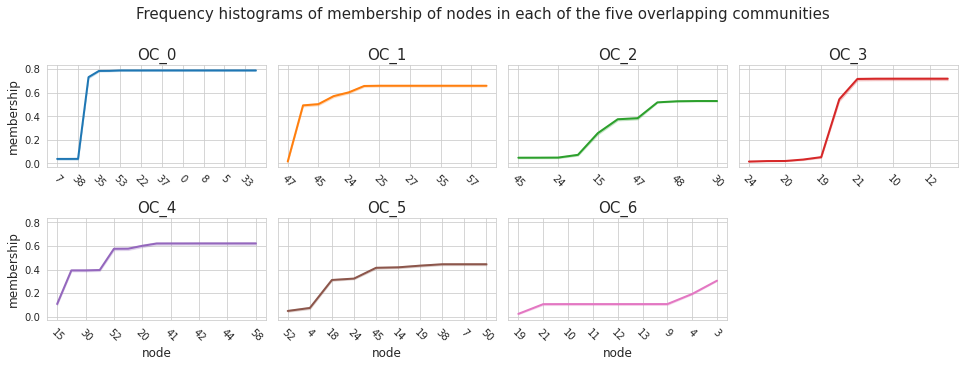

In [189]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    sns.histplot(
        data=selected_df,
        x='membership',
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    axes[i, j].set_xticks(bins)
    
    axes[i, j].set_ylabel('Probability', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities (NMF approach)'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5), sharey='all')

num_ticks = 10
for idx in tqdm(df.OC_idx.unique(), leave=False):
    i, j = idx//4, idx%4
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    nodes_sorted = selected_df.groupby('node').mean().sort_values('membership').index.tolist()
    node_rank = {node: i for i, node in enumerate(nodes_sorted)}
    ranked_df = pd.concat([selected_df, pd.DataFrame(columns=['node_rank'])], axis=1)
    ranked_df.loc[:, 'node_rank'] = [node_rank[node] for node in ranked_df.node]

    sns.lineplot(
        data=ranked_df,
        x='node_rank',
        y='membership',
        color='C{:d}'.format(idx),
        lw=2,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    
    delta = int(np.ceil(len(node_rank) / num_ticks))
    xticks = range(0, len(node_rank), delta)
    xtick_labels = np.array(list(node_rank))[xticks]
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xtick_labels, rotation=-45)
    axes[i, j].set_ylabel('membership', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('node', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

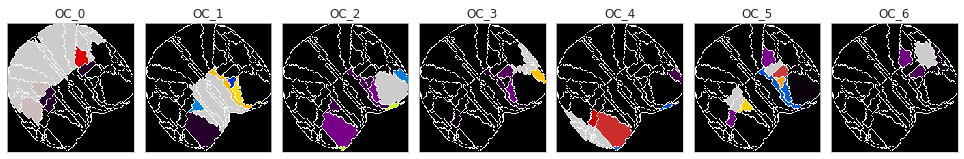

In [190]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap='nipy_spectral')
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

#### Another th

In [191]:
th = 0.80
n = 2000
g = nx.from_numpy_matrix(corrs['spearman'][th])

# get results
results_leiden = defaultdict(list)
for i in tqdm(range(n)):
    coms = cdlib_algorithms.leiden(g, weights='weight')
    community_list = sorted(coms.communities, key=lambda x: len(x), reverse=True)
    partition = convert('community', 'partition', community=community_list)
    output = filter_islands(partition, load['atlas'], node_labels, min_com_size=3)
    q = nx_comm.modularity(g, communities=community_list)
    num_comm = len(set(partition.values()))

    comm_proto = {}
    for j in range(num_comm):
        a = np.zeros_like(output['comm_mat'])
        a[output['comm_mat'] == j] = 1
        comm_proto[j] = a.flatten()

    results = Leiden(
        idx=i,
        num_comm=num_comm,
        modularity=q,
        partition=partition,
        comm_mat=output['comm_mat'],
        comm_proto=comm_proto,
    )
    results_leiden[num_comm].append(results)

results_leiden = dict(results_leiden)
results_leiden = dict(sorted(results_leiden.items(), key=lambda x: len(x[1]), reverse=True))


# get modularity values
q_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        q_leiden[k].append(result.modularity)
q_leiden = dict(q_leiden)


# get prototypes
proto_leiden = defaultdict(list)
for k, v in results_leiden.items():
    for result in v:
        for proto in result.comm_proto.values():
            proto_leiden[k].append(proto)
proto_leiden = dict(proto_leiden)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [192]:
{k: len(v) for k, v in results_leiden.items()}

{7: 1753, 6: 217, 8: 30}

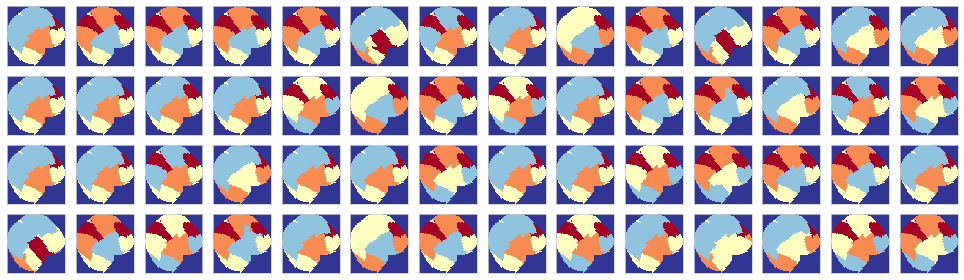

In [193]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[0]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

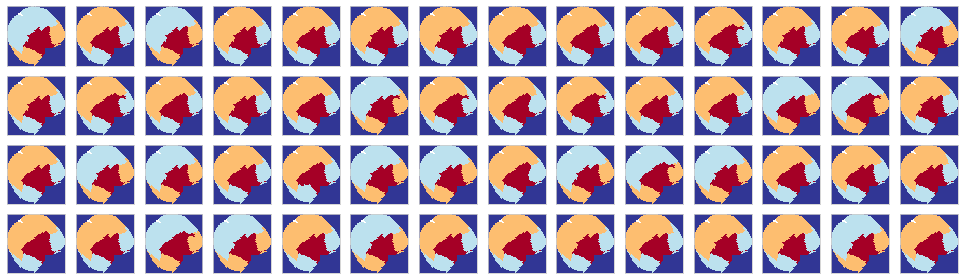

In [194]:
nrows, ncols = 4, 14
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 4))

plot_material = list(results_leiden.values())[1]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    try:
        axes[i, j].imshow(plot_material[idx].comm_mat, cmap='RdYlBu_r', interpolation='none')
    except IndexError:
        fig.delaxes(axes[i, j])
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
fig.tight_layout()
plt.show()

...merging dicts: 0it [00:00, ?it/s]

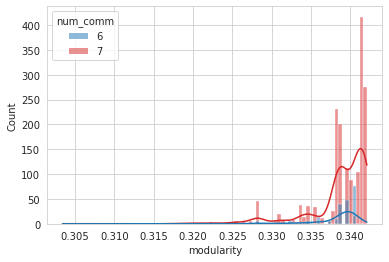

In [195]:
dict_list = []

for k, v in q_leiden.items():
    if len(v) < n / 20:
        continue
    dict_list.append({'num_comm': [k] * len(v), 'modularity': v})

sns.set_style('whitegrid')
sns.histplot(
    data=pd.DataFrame.from_dict(merge_dicts(dict_list)),
    x='modularity',
    hue='num_comm',
    palette=['C0', 'C3'],
    kde=True,
)
plt.show()

In [200]:
proto_all = [x.reshape(1, -1) for item in proto_leiden.values() for x in item]
proto_all = np.concatenate(proto_all)
proto_all.shape

(13813, 35340)

In [201]:
n_clusters = list(results_leiden.keys())[0]

kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
).fit(proto_all)

In [202]:
# from sklearn.preprocessing import normalize as sk_normalize
from copy import deepcopy as dc

In [203]:
clusters = dc(kmeans.cluster_centers_)
clusters_binarized = dc(kmeans.cluster_centers_)
clusters_binarized
clusters_binarized[clusters_binarized <= 0.01] = 0
clusters_binarized[clusters_binarized > 0.01] = 1

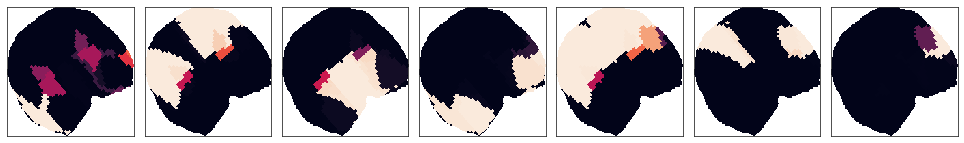

In [204]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

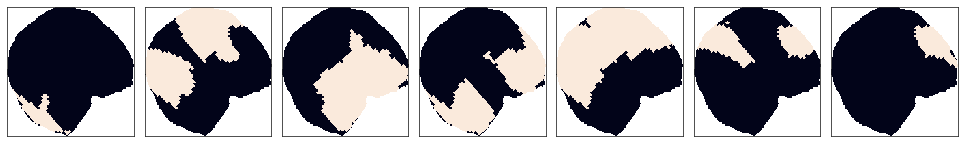

In [205]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

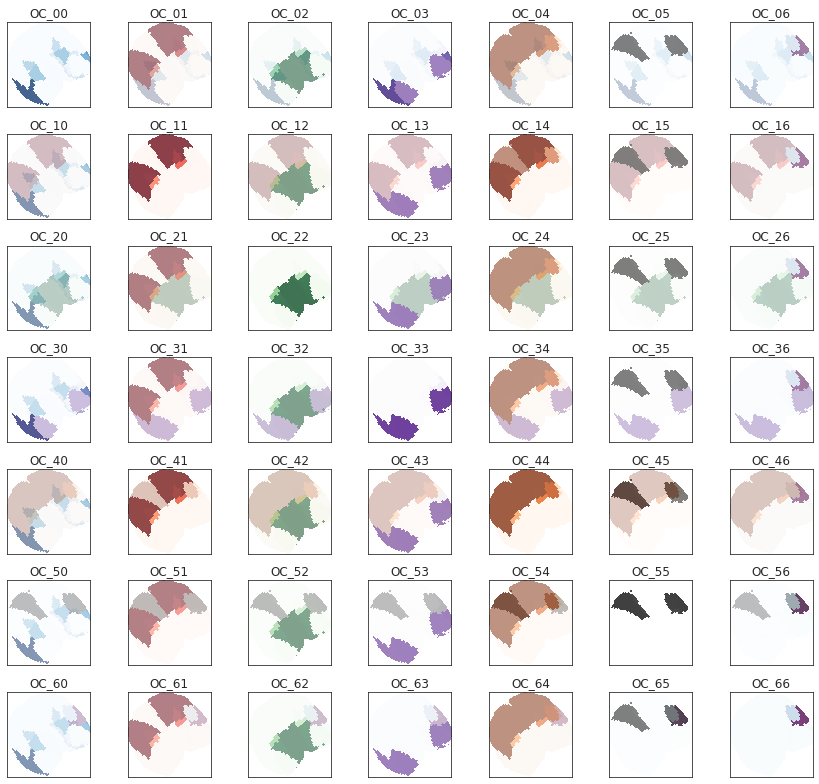

In [206]:
cmaps = {
    0: 'Blues',
    1: 'Reds',
    2: 'Greens',
    3: 'Purples',
    4: 'Oranges',
    5: 'Greys',
    6: 'BuPu',
}


fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

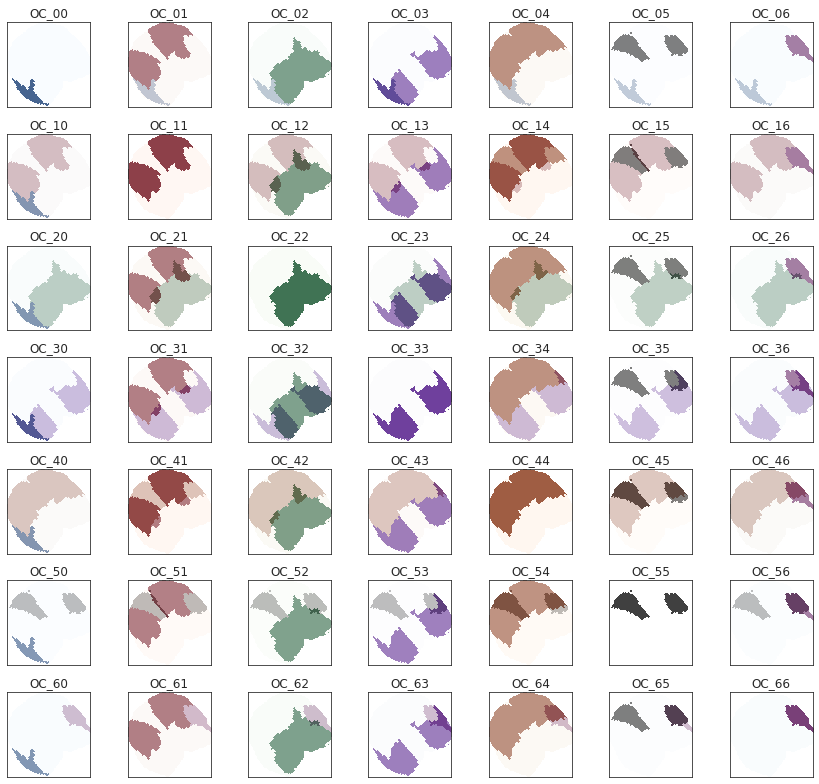

In [207]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

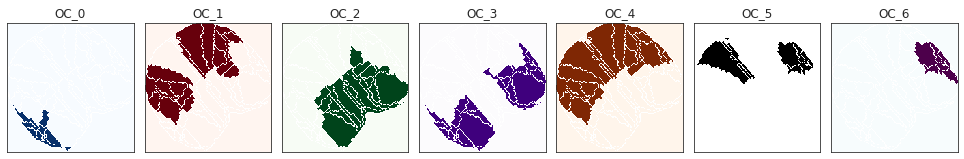

In [208]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

In [209]:
results_leiden_fixed = []

for result in tqdm(results_leiden[n_clusters], leave=False):
    b = np.ones_like(result.comm_mat) * -1
    for i in range(n_clusters):
        a = np.zeros_like(result.comm_mat)
        a[result.comm_mat == i] = 1
        cluster_idx = kmeans.predict(a.reshape(1, -1)).item()
        b[result.comm_mat == i] = cluster_idx
    results_leiden_fixed.append(b[np.newaxis, ...])
    
results_leiden_fixed = np.concatenate(results_leiden_fixed)
avg_leiden = results_leiden_fixed.mean(0)

results_leiden_fixed.shape, avg_leiden.shape

  0%|          | 0/1753 [00:00<?, ?it/s]

((1753, 190, 186), (190, 186))

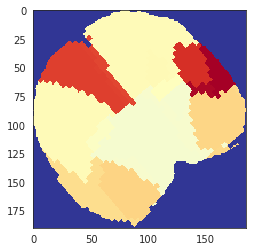

In [210]:
plt.imshow(avg_leiden, cmap='RdYlBu_r', interpolation='none')

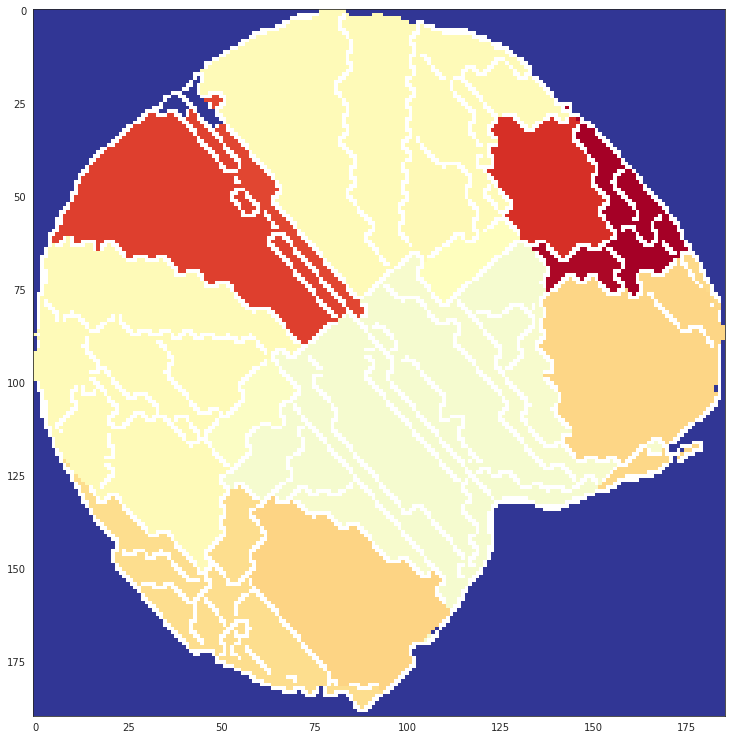

In [211]:
plt.figure(figsize=(15, 13))
plt.imshow(np.ma.masked_where(atls_org['contour'], avg_leiden), cmap='RdYlBu_r', interpolation='none')
plt.show()

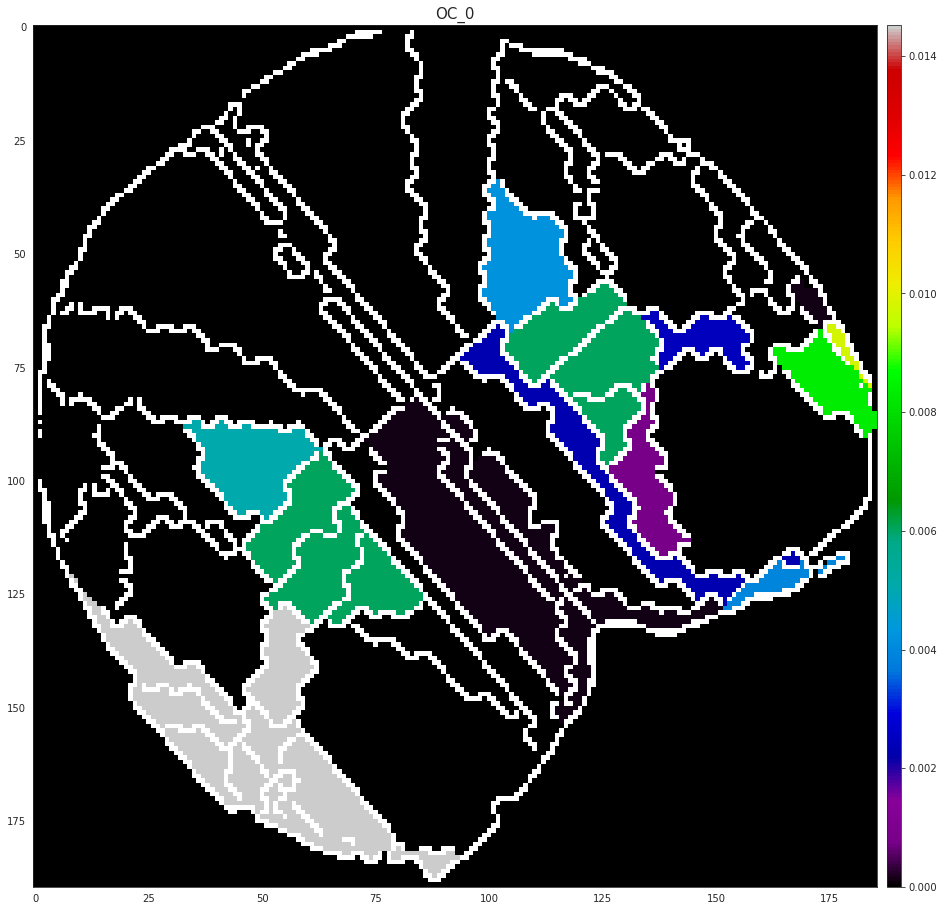

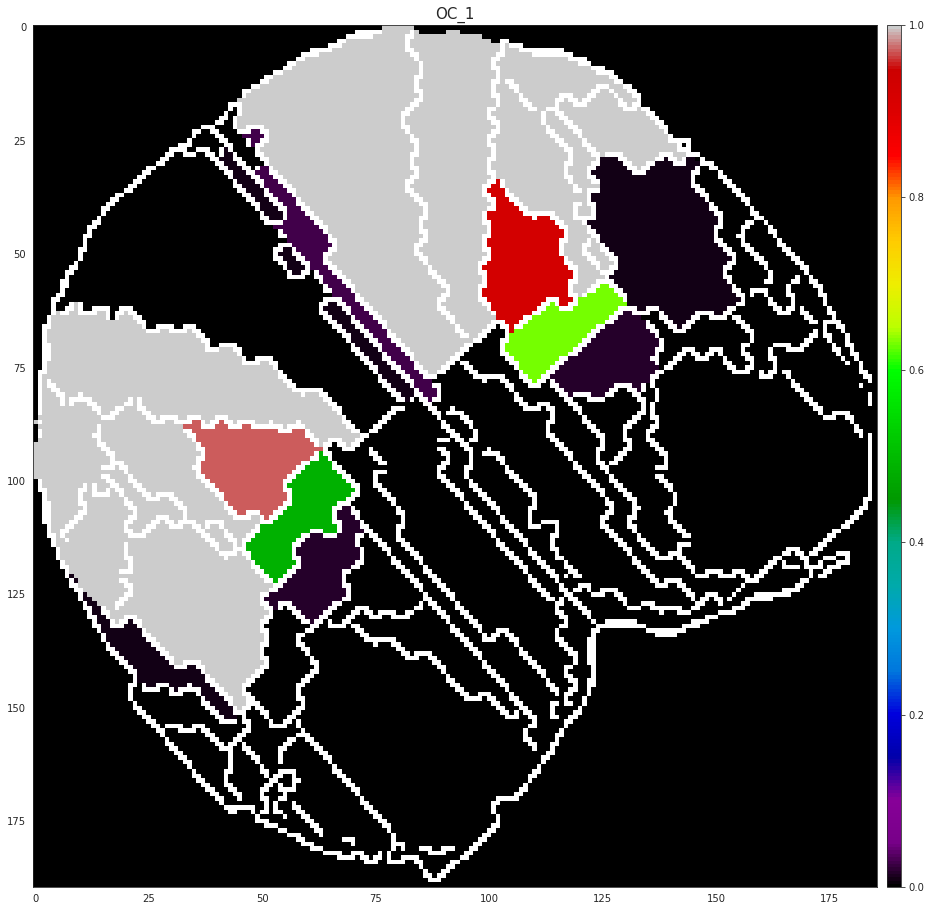

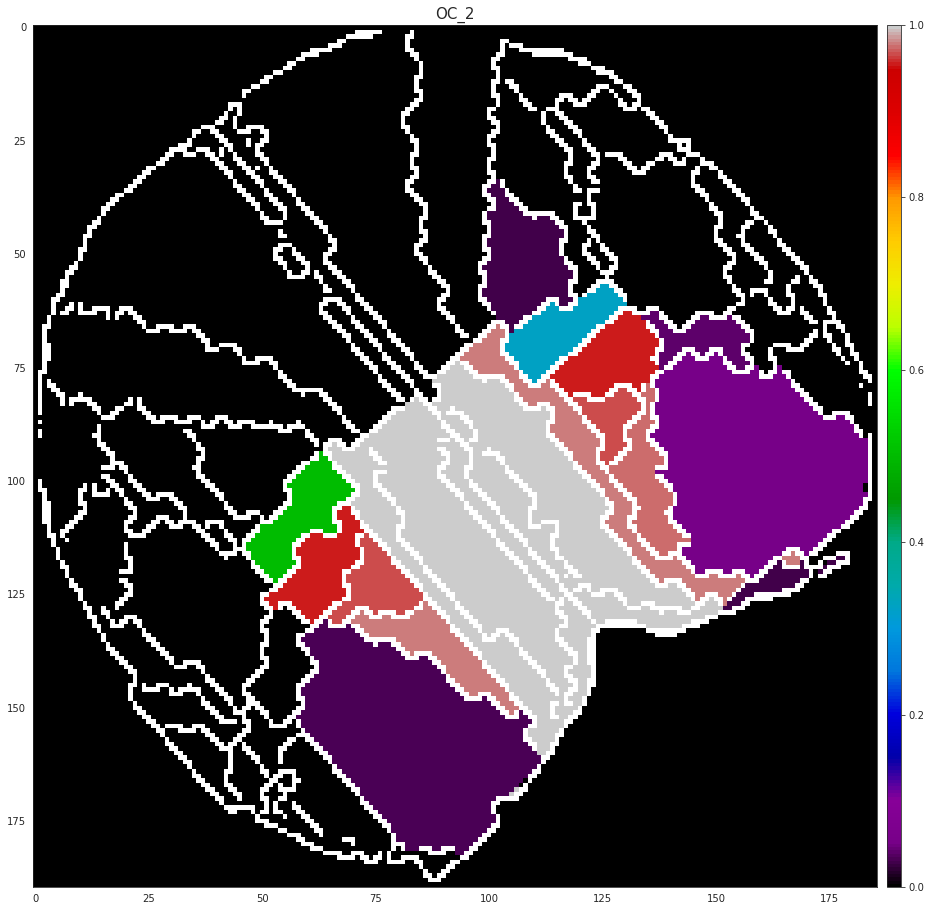

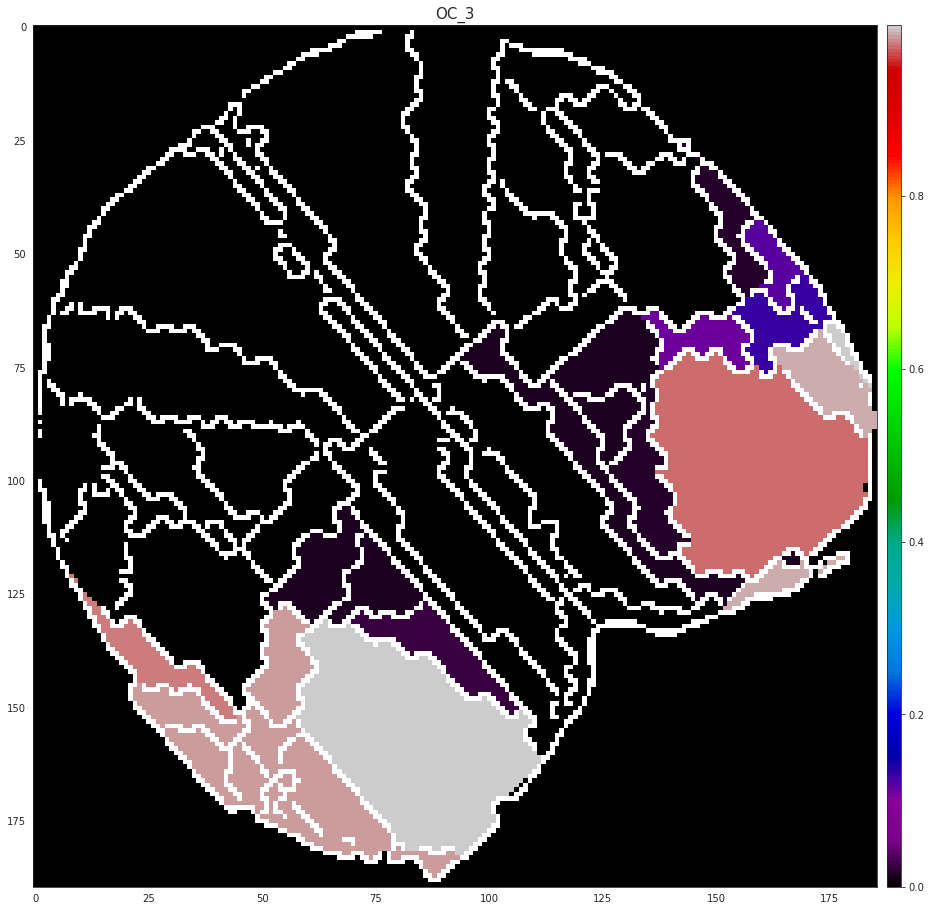

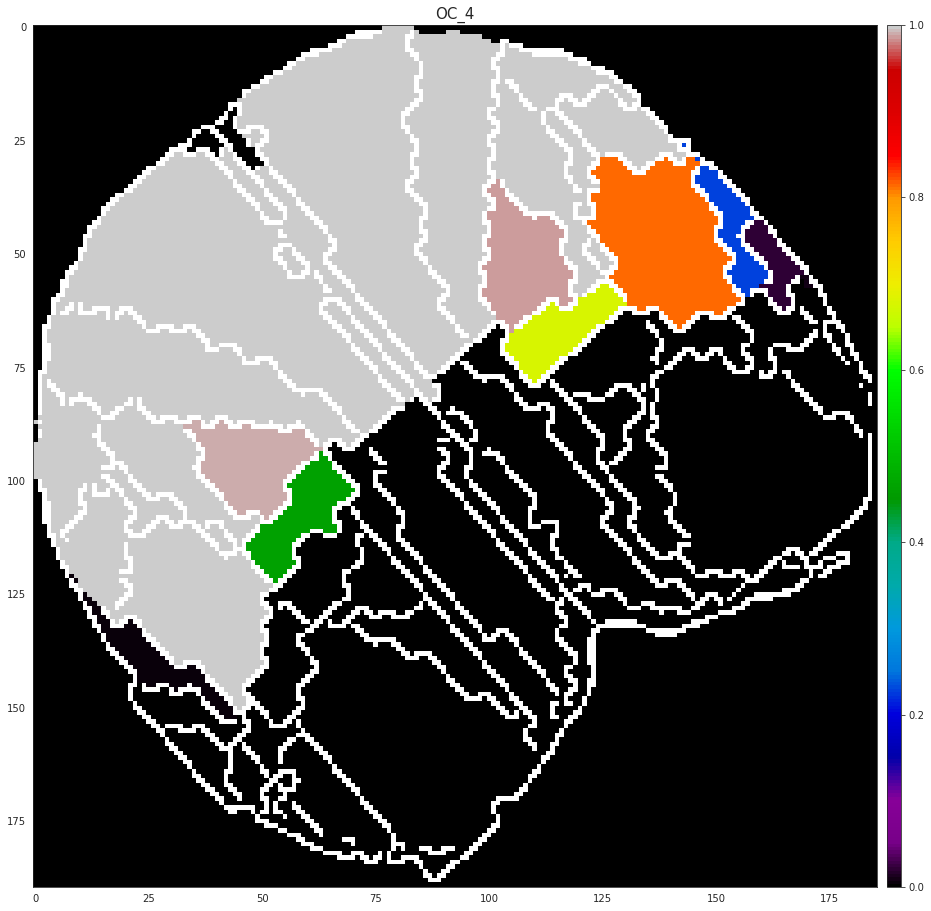

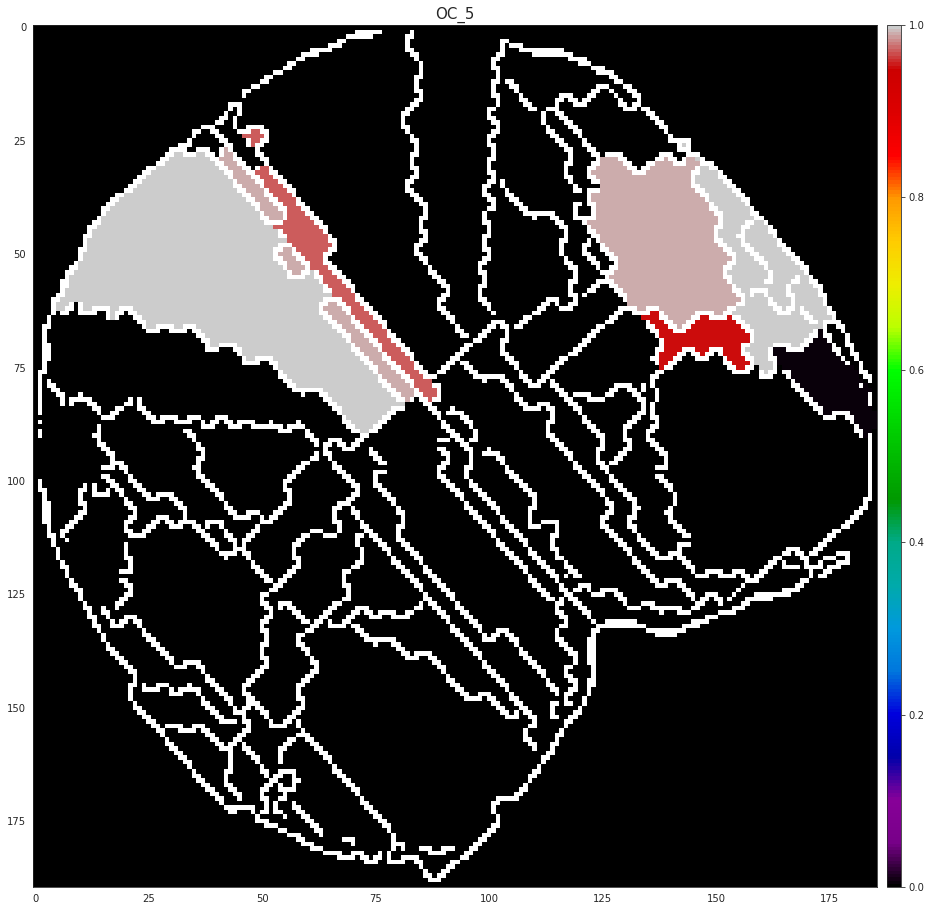

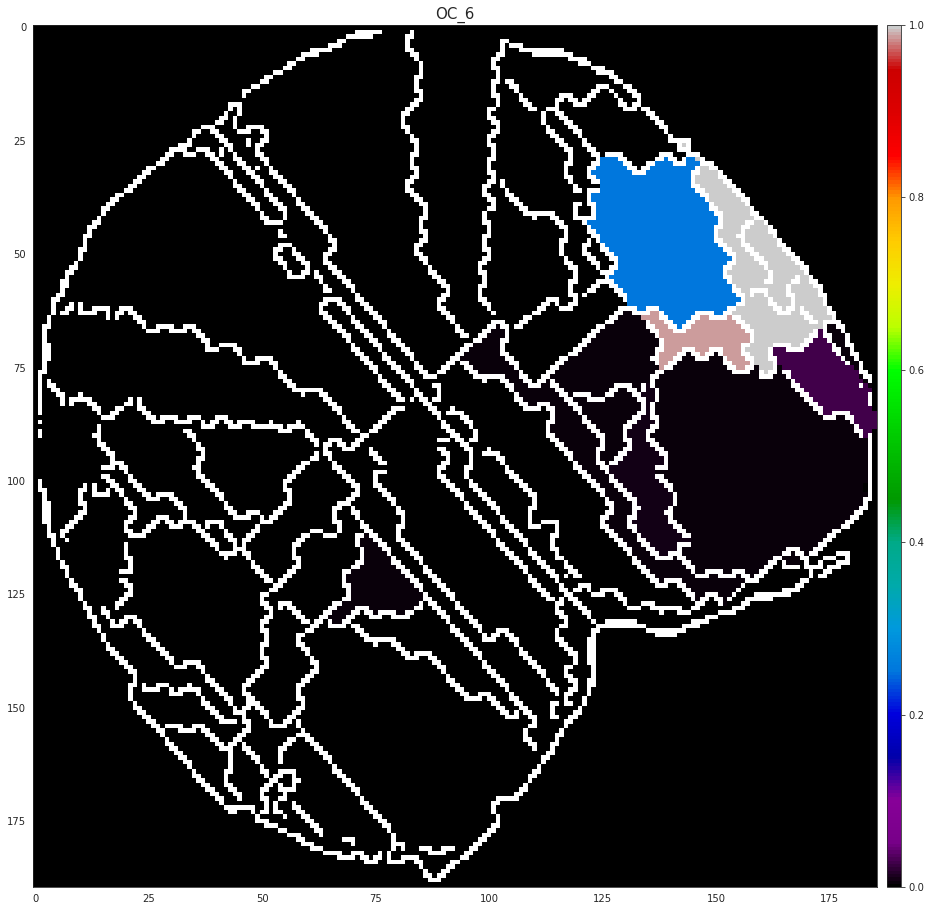

In [212]:
for i in range(n_clusters):
    plt.figure(figsize=(18, 17))
    c = clusters[i].reshape(load['atlas'].shape)
    plt.imshow(np.ma.masked_where(atls_org['contour'], c), cmap='nipy_spectral', interpolation='none')
    plt.colorbar(pad=0.01, shrink=0.933, aspect=60)
    plt.title('OC_{:d}'.format(i), fontsize=15)
    plt.show()

In [213]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        _proto = [item.reshape(1, -1) for item in result.comm_proto.values()]
        canonical_idxs = kmeans.predict(np.concatenate(_proto))
        reindexing = {i: key for i, key in enumerate(canonical_idxs)}
        canonical_partition = {node: reindexing[comm_idx] for node, comm_idx in result.partition.items()}
        nodes, canonical_comm_idxs = tuple(zip(*canonical_partition.items()))
        
        data_dict = {
            'num_comm': [k] * len(nodes),
            'node': nodes,
            'OC_idx': canonical_comm_idxs,
        }
        dict_list.append(data_dict)
        
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1753 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [214]:
memberships = np.zeros((n_clusters, len(df.node.unique())))

for node in df.node.unique():
    selected_df = df.loc[df.node == node]
    for idx, num in collections.Counter(selected_df.OC_idx).most_common():
        memberships[idx, node] = num / len(selected_df)


node2roi = {node: load['atlas'] == node_labels[node] for node in g.nodes}

cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

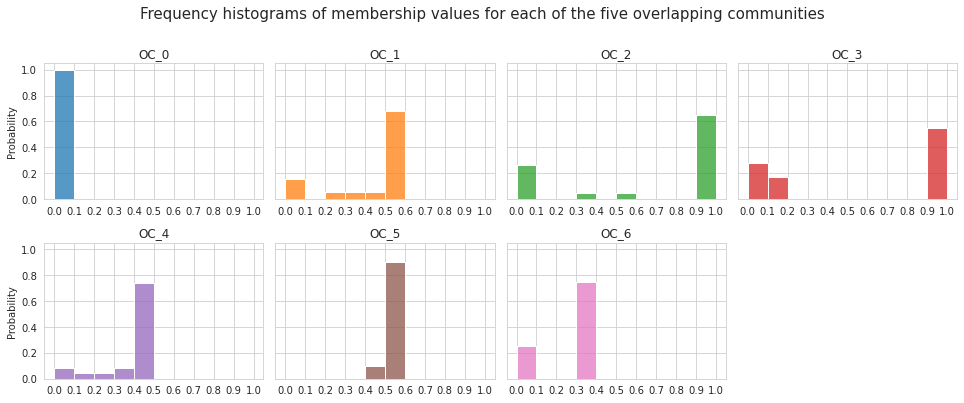

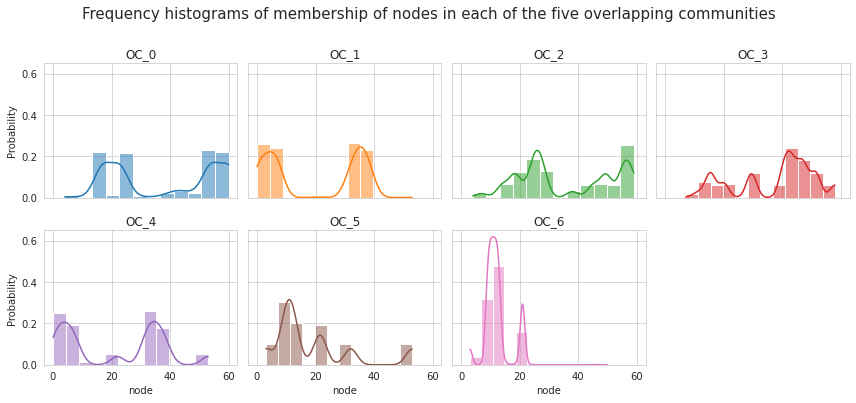

In [215]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    sns.histplot(
        memberships[idx][cluster_members[idx]],
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
    axes[i, j].set_xticks(bins)
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(12, 5.5), sharex='all', sharey='all')

for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    selected_df = df.loc[df.OC_idx == idx]
    sns.histplot(
        data=selected_df,
        x='node',
        stat='probability',
        bins=12,
        color='C{:d}'.format(idx),
        kde=True,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx))
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

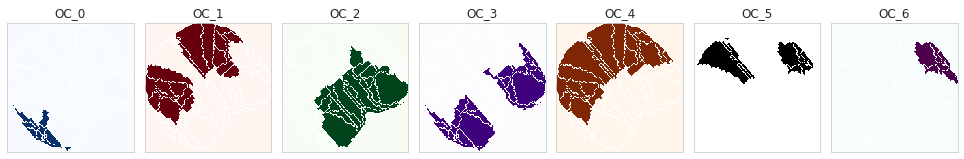

In [216]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap=cmaps[i])
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

### NMF?

In [217]:
from sklearn.decomposition import NMF

In [218]:
nmf = NMF(
    n_components=n_clusters,
    init='nndsvd',
    random_state=42,
)

In [219]:
nmf_pred = nmf.fit_transform(proto_all)

In [220]:
nmf.reconstruction_err_

894.19521514541

In [221]:
from copy import deepcopy as dc

In [222]:
nmf_clusters = dc(nmf.components_)
nmf_clusters_binarized = dc(nmf.components_)
nmf_clusters_binarized[nmf_clusters_binarized <= 0.01] = 0
nmf_clusters_binarized[nmf_clusters_binarized > 0.01] = 1

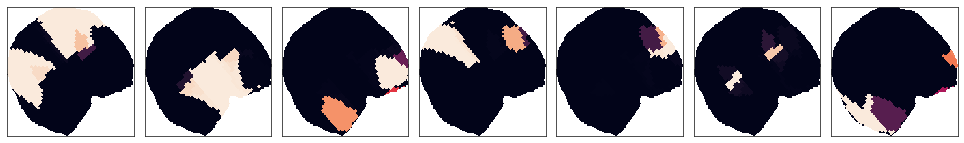

In [223]:
sns.set_style('white')
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

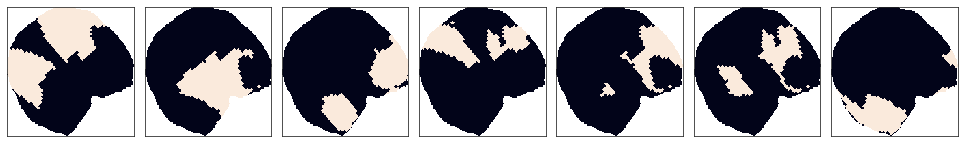

In [224]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()

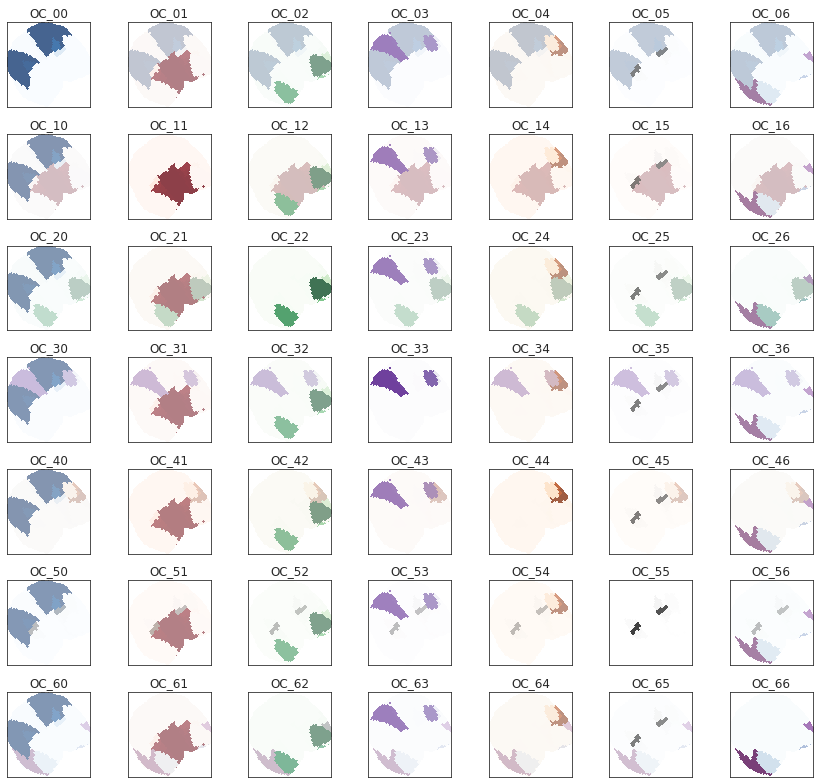

In [225]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

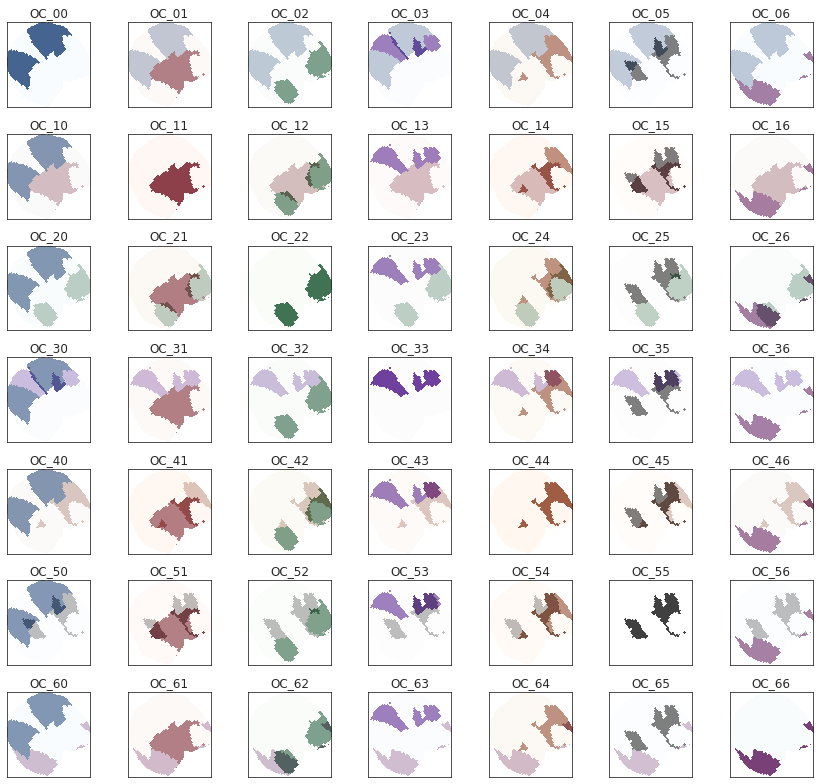

In [226]:
fig, axes = plt.subplots(n_clusters, n_clusters, figsize=(12, 11))

for i in range(n_clusters):
    c1 = nmf_clusters_binarized[i].reshape(load['atlas'].shape)
    for j in range(n_clusters):
        c2 = nmf_clusters_binarized[j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c1), interpolation='none', cmap=cmaps[i], alpha=0.5)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c2), interpolation='none', cmap=cmaps[j], alpha=0.5)
        axes[i, j].set_title('OC_{:d}{:d}'.format(i, j))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

fig.tight_layout()
plt.show()

In [227]:
node2roi = {node: load['atlas'] == node_labels[node] for node in g.nodes}
cluster_members = {
    idx: [
        node for node, roi in node2roi.items()
        if (roi * nmf_clusters_binarized[idx].reshape(roi.shape)).sum()
    ]
    for idx in range(n_clusters)
}

In [228]:
dict_list = []
for k, v in results_leiden.items():
    for result in tqdm(v, leave=False):
        for proto_vec in result.comm_proto.values():
            pred = nmf.transform(proto_vec.reshape(1, -1))
            pred = pred.flatten()
            if pred.sum() > 0:
                pred /= pred.sum()

            nodes_inside = list(itertools.compress(
                data=list(node2roi.keys()),
                selectors=[(roi*proto_vec.reshape(roi.shape)).sum() for roi in node2roi.values()]
            ))
            for node in nodes_inside:
                data_dict = {
                    'num_comm': [k] * len(pred),
                    'node': [node] * len(pred),
                    'OC_idx': range(len(pred)),
                    'membership': pred,
                }
                dict_list.append(data_dict)

df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1753 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

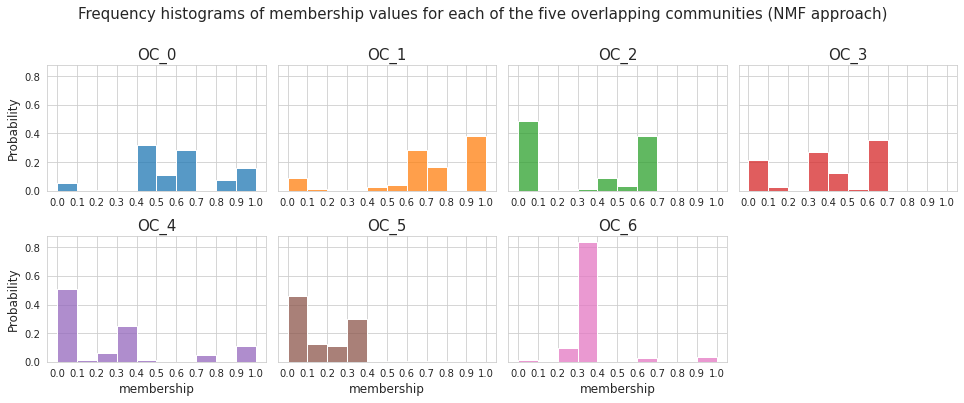

  0%|          | 0/7 [00:00<?, ?it/s]

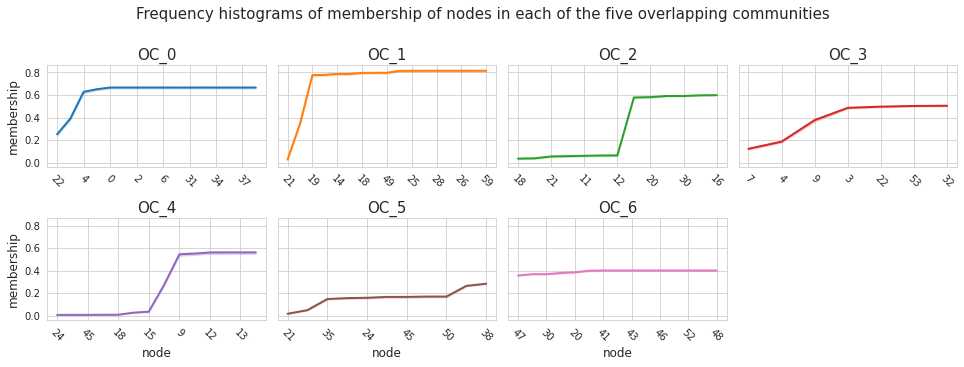

In [229]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5.5), sharey='all')

bins = np.linspace(0, 1.0, 11)
for idx in df.OC_idx.unique():
    i, j = idx//4, idx%4
    
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    sns.histplot(
        data=selected_df,
        x='membership',
        bins=bins,
        stat='probability',
        color='C{:d}'.format(idx),
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    axes[i, j].set_xticks(bins)
    
    axes[i, j].set_ylabel('Probability', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('membership', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership values for each of the five overlapping communities (NMF approach)'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()


print('\n\n')


sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 4, figsize=(13.5, 5), sharey='all')

num_ticks = 10
for idx in tqdm(df.OC_idx.unique(), leave=False):
    i, j = idx//4, idx%4
    selected_df = df.loc[(df.OC_idx == idx) & df.node.isin(cluster_members[idx])]
    nodes_sorted = selected_df.groupby('node').mean().sort_values('membership').index.tolist()
    node_rank = {node: i for i, node in enumerate(nodes_sorted)}
    ranked_df = pd.concat([selected_df, pd.DataFrame(columns=['node_rank'])], axis=1)
    ranked_df.loc[:, 'node_rank'] = [node_rank[node] for node in ranked_df.node]

    sns.lineplot(
        data=ranked_df,
        x='node_rank',
        y='membership',
        color='C{:d}'.format(idx),
        lw=2,
        ax=axes[i, j],
    )
    axes[i, j].set_title('OC_{:d}'.format(idx), fontsize=15)
    
    delta = int(np.ceil(len(node_rank) / num_ticks))
    xticks = range(0, len(node_rank), delta)
    xtick_labels = np.array(list(node_rank))[xticks]
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xtick_labels, rotation=-45)
    axes[i, j].set_ylabel('membership', fontsize=12)
    if i == 1:
        axes[i, j].set_xlabel('node', fontsize=12)
    else:
        axes[i, j].set_xlabel('')
fig.delaxes(axes[-1, -1])
msg = 'Frequency histograms of membership of nodes in each of the five overlapping communities'
fig.suptitle(msg, fontsize=15, y=1.01)
fig.tight_layout()
plt.show()

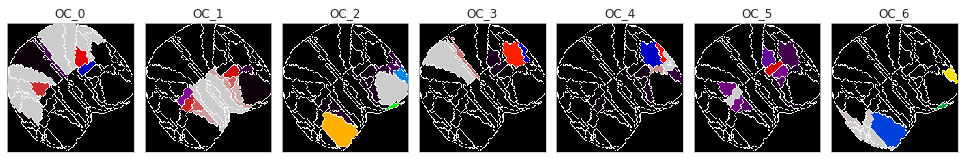

In [230]:
fig, axes = plt.subplots(1, n_clusters, figsize=(13.5, 4))

for i in range(n_clusters):
    c = nmf_clusters[i].reshape(load['atlas'].shape)
    axes[i].imshow(np.ma.masked_where(atls_org['contour'], c), interpolation='none', cmap='nipy_spectral')
    axes[i].set_title('OC_{:d}'.format(i))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
fig.tight_layout()
plt.show()